In [1]:
"""
Lagrangian DA for the 2-layer QG system
"""

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde, norm
from Lagrangian_tracer import Lagrange_tracer_model
from conj_symm_tools import verify_conjugate_symmetry, find_non_conjugate_pairs, avg_conj_symm
from Lagrangian_DA import Lagrangian_DA_OU, Lagrangian_DA_CG, mu2psi
from ene_spectrum import ene_spectrum, adjust_ik, trunc2full
from LSM_QG import solve_eigen, calibrate_OU, run_OU, eigen2layer, layer2eigen
from mode_truc import inv_truncate, truncate
from statsmodels.tsa.stattools import acf, ccf
from scipy.optimize import curve_fit
from scipy.io import loadmat
import h5py
from scipy import sparse
from time import time

# fix the random seed
np.random.seed(2024)


# 1. Lagrangian DA with Linear Stochastic Model

## 1.1 Perfect Model (LSM as truth)

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-5_beta22_K16_dt1e-4.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 100000)


In [3]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

# np.save('../data/eigens_K16_beta22.npy', eigens)
# np.where(np.isnan(r1))

In [4]:
# Model calibration
est_params = calibrate_OU(r1, r2, psi1_k_t, psi2_k_t, K, dt, Lag=60000, r_cut=7, style='square')
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est_ca = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

# np.save('../data/est_paras_ou_K16_beta22.npy', est_params)

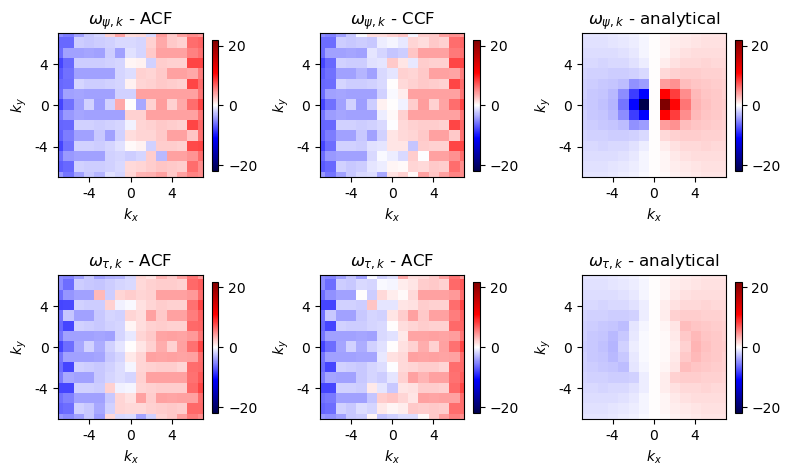

In [35]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est_ca[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est_ca[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = 7

for i in range(2):
    for j in range(3):
        n_tick = 4
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K16_beta22.png', dpi=100)
plt.show()

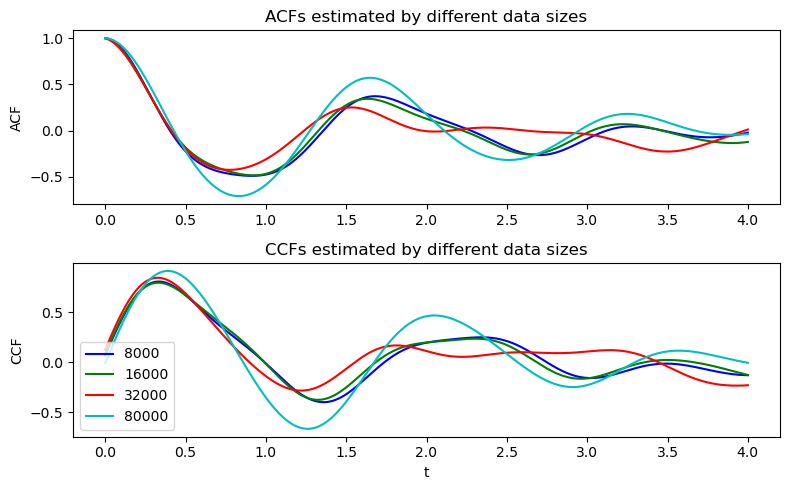

In [38]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [8000, 16000, 32000, 80000]
Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 5; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K16_beta22.png')
plt.show()

In [6]:
# Truth of eigenmodes
r_cut = 7
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style='square')

# # save data
# psi_k_truth = {
#     'psi_k_t': psi_k_t,
#     'tau_k_t': tau_k_t,
#     'cut': cut
# }
# np.savez('../data/psi_k_truth_K16_beta22.npz', **psi_k_truth)

In [7]:
# Run OU process
# get the initial condition
N = 100000
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est_ca, f_est, sigma_est, style='square')

# # save data
# ou_run = {
#     'psi_k': psi_k,
#     'tau_k': tau_k,
#     'N': N,
#     'cut':cut,
#     'dt': dt
# }
# np.savez('../data/ou_run_K16_beta22.npz', **ou_run)

In [11]:
# ifft to real space
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k, style='square')
psi1_ifft = np.fft.ifft2(psi1_k, axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t, axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k, axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t, axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

# # save data
# psi_ou_truth = {
#     'psi1_ifft': psi1_ifft,
#     'psi1_ifft_t': psi1_ifft_t,
#     'psi2_ifft': psi2_ifft,
#     'psi2_ifft_t': psi2_ifft_t,
#     'N': N,
#     'cut': cut
# }
# np.savez('../data/psi_ou_truth_K16_beta22.npz', **psi_ou_truth)

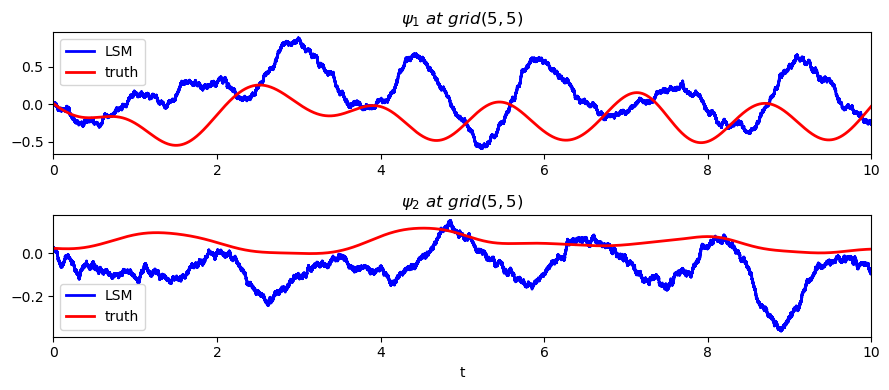

In [42]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi1_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi1_ifft_t[mode,mode,:N]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi2_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi2_ifft_t[mode,mode,:N]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K16_beta22.png', dpi=100)
plt.show()

In [8]:
# energy spectrum of eigenmodes
t_avrg = 10000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

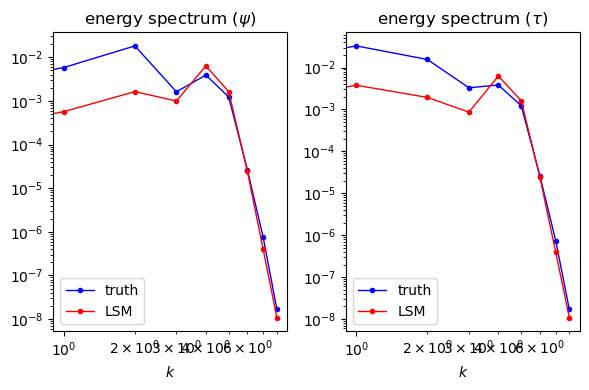

In [15]:
# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K16_beta22.png', dpi=100)
plt.show()

what happened to the first few modes?

In [10]:
# energy spectrum of layers
t_avrg = 10000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k, style='square')
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

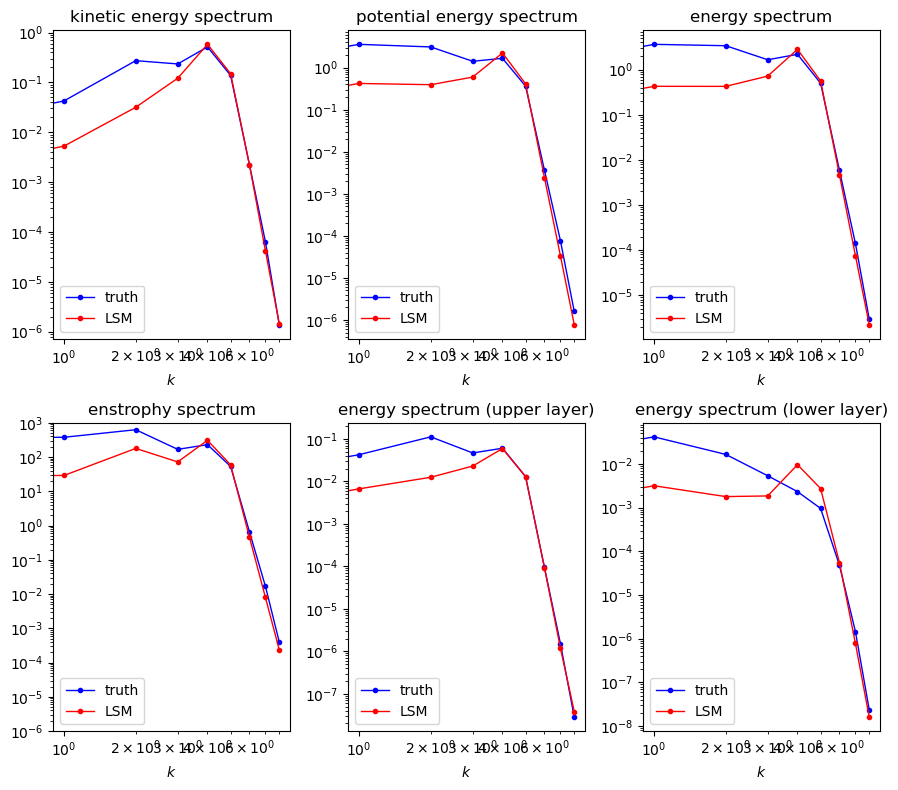

In [19]:
# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-6, 1000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K16_beta22.png', dpi=100)
plt.show()

In [3]:
# load data of LSM
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']
est_params = np.load('../data/est_paras_ou_K16_beta22.npy', allow_pickle=True).item()
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']
ou_run = np.load('../data/ou_run_K16_beta22.npz')
psi_k = ou_run['psi_k']
tau_k = ou_run['tau_k']
cut = ou_run['cut']
obs = np.load('../data/obs_K16_beta22_ou.npz')
xt = obs['xt']
yt = obs['yt']
ut = obs['ut']
vt = obs['vt']
sigma_xy = obs['sigma_xy']
L = obs['L']

# truth is from OU run
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k)

In [20]:
# run obs model
L = 256 # number of tracers
K = psi1_k.shape[0]
N = psi1_k.shape[-1]
sigma_xy = 0.01
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k, dt, sigma_xy, x0, y0, interv=8, t_interv=100000, style='square')
xt, yt, ut, vt = model.forward()   

# # save data
# obs = {
#     'xt': xt,
#     'yt': yt,
#     'ut': ut,
#     'vt': vt,
#     'sigma_xy': sigma_xy,
#     'L': L,
#     'dt': dt
# }
# np.savez('../data/obs_K16_beta22_ou.npz', **obs)

In [24]:
# Lagrangian DA
# r_cut = 7
# N = 100000
N_chunk = 200
lsm_da = Lagrangian_DA_OU(N, N_chunk, K, psi_k, tau_k, r1, r2, dt, sigma_xy, f_est, gamma_est, omega_est_ca, sigma_est, xt.T, yt.T, r_cut, style='square')
mu_t, R_t = lsm_da.forward()

In [25]:
# reshape flattened variables to two modes matrices
psi_k_pos, tau_k_pos = mu2psi(mu_t, K, r_cut, 'square')

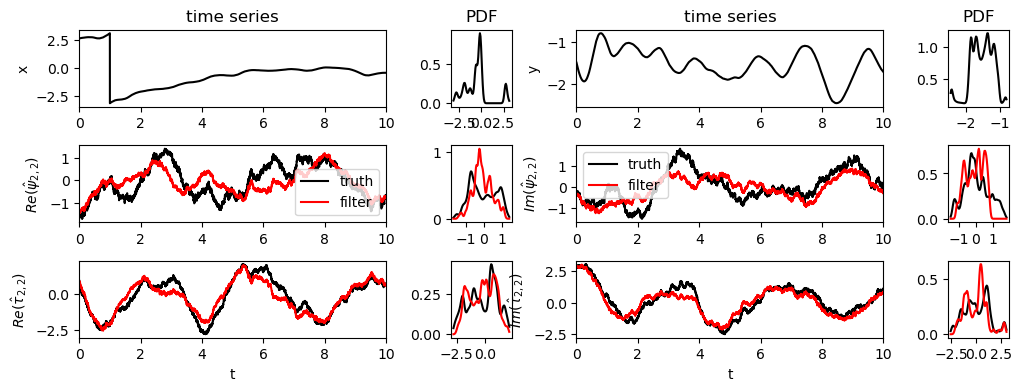

In [34]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k',label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_k[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_k[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
ax4.set_title('PDF')

samples = psi_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = tau_k[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_k[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_k[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
ax44.set_title('PDF')

samples = psi_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = tau_k[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')
plt.savefig('./Lagrangian_DA/LagDA_LSM_K16_L256_perfmodel.png',dpi=100)
plt.show()

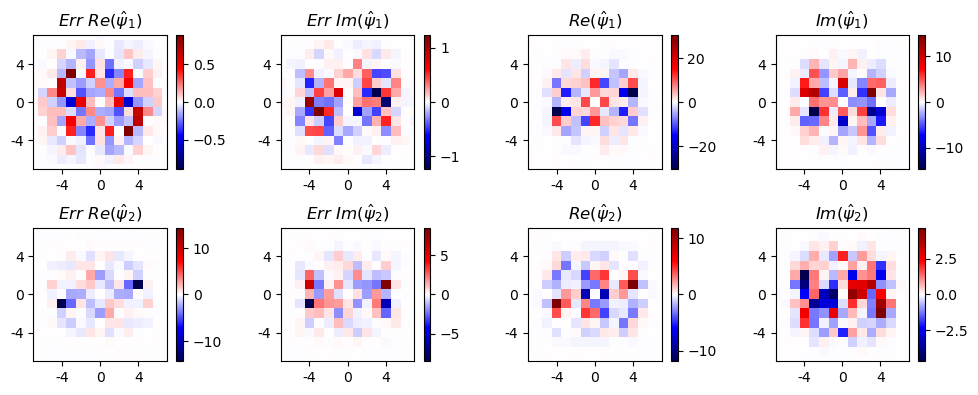

In [32]:
# plot error mode
# psi_k_pos_KK = inv_truncate(np.reshape(psi_k_pos, (psi_k_pos.shape[0]**2, -1), order='F'), r_cut, K, style='square')
# tau_k_pos_KK = inv_truncate(np.reshape(tau_k_pos, (tau_k_pos.shape[0]**2, -1), order='F'), r_cut, K, style='square')
psi1_k_pos_KK, psi2_k_pos_KK = eigen2layer(K,r_cut,r1,r2,psi_k_pos,tau_k_pos,'square')

fig, axs = plt.subplots(2, 4, figsize=(10,4))

dataplot = np.zeros((K,K,2,4))
dataplot[:,:,0,0] = (psi1_k_pos_KK[:, :, -1] - psi1_k[:, :, -1]).real
dataplot[:,:,0,1] = (psi1_k_pos_KK[:, :, -1] - psi1_k[:, :, -1]).imag
dataplot[:,:,0,2] = psi1_k[:, :, -1].real
dataplot[:,:,0,3] = psi1_k[:, :, -1].imag
dataplot[:,:,1,0] = (psi2_k_pos_KK[:, :, -1] - psi2_k[:, :, -1]).real
dataplot[:,:,1,1] = (psi2_k_pos_KK[:, :, -1] - psi2_k[:, :, -1]).imag
dataplot[:,:,1,2] = psi2_k[:, :, -1].real
dataplot[:,:,1,3] = psi2_k[:, :, -1].imag

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(2):
    for j in range(4):
        n_tick = 4
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])

axs[0,0].set_title(f'$Err\ Re(\hat{{\psi}}_1)$')
axs[0,1].set_title(f'$Err\ Im(\hat{{\psi}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}_1)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}_1)$')
axs[1,0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1,1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/lsmda_err_psi_k_K16_fullQG_beta22_perfmodel.png', dpi=100)
plt.show()

In [28]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k)
psi2_t = np.zeros_like(psi2_k)
psi1_pos = np.zeros_like(psi1_k_pos_KK)
psi2_pos = np.zeros_like(psi2_k_pos_KK)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k[:, :, i])
    psi1_pos[:,:,i] = np.fft.ifft2(psi1_k_pos_KK[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(psi2_k_pos_KK[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi1_pos = np.real(psi1_pos)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=0)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

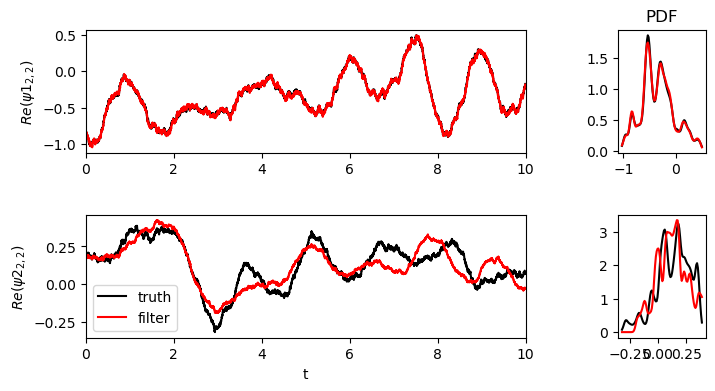

In [31]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.plot(xaxis, psi1_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k', label='truth')
samples = psi1_pos[iky, ikx, :]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'r', label='filter')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K16_fullQG_beta22_perfmodel_real.png',dpi=100)
plt.show()

In [30]:
# RMSE
rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(upper layer): 0.01782143051994947
RMSE(lower layer): 0.07977471412594567


## 1.2 Imperfect Model (QG vs LSM)

### 1.2.1 Full mode (K=16)

In [7]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = 100000 #psi1_hat_t.shape[2]
Kx = np.fft.fftfreq(K) * K
Ky = np.fft.fftfreq(K) * K
sigma_xy = 0.01
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, Kx, Ky, psi1_k_t, dt, sigma_xy, x0, y0, interv=1)
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K16_beta22.npz', **obs)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


In [ ]:
# Lagrangian DA
def truncate(kk, cut):
    '''require the input kk has shape (K,) or (K,K,...)'''
    K = kk.shape[0]

    if kk.ndim == 1:
        index_to_remove = np.zeros(K, dtype=bool)
        index_to_remove[(K//2-cut):(K//2+cut+1)] = True
    elif kk.ndim > 1:
        index_to_remove = np.zeros_like(kk, dtype=bool)
        index_to_remove[(K//2-cut):(K//2+cut+1), :] = True
        index_to_remove[:, (K//2-cut):(K//2+cut+1)] = True
        new_shape = np.array(kk.shape)
        new_shape[:2] -= (2*cut+1)

    return kk[~index_to_remove].reshape(new_shape)

def get_A(x,y,K,r1,r2,cut):
    L = x.shape[0]
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    KX = truncate(KX, cut)
    KY = truncate(KY, cut)
    r1 = truncate(r1[:,:,0], cut)
    r2 = truncate(r2[:,:,0], cut)
    E = np.zeros((2*L, (K-2*cut-1)**2), dtype=np.complex_)

    exp_term = np.exp(1j * x[:,None] @ KX.flatten(order='F')[None,:] + 1j * y[:,None] @ KY.flatten(order='F')[None,:])
    E[:L,:] = exp_term * (1j) * KY.flatten(order='F')
    E[L:,:] = exp_term * (-1j) * KX.flatten(order='F')
#     R_bot = sparse.hstack([sparse.diags(r1.flatten(order='F')), sparse.diags(r2.flatten(order='F'))], format="csr")
#     A = sparse.csr_matrix(E).dot(R_bot)
    R_bot = np.hstack([np.diag(r1.flatten(order='F')), np.diag(r2.flatten(order='F'))])
    A = E @ R_bot / K**2

    return A


N = 100000
# Sigma1 = np.array(sigma_xy)[None, None]
# invBoB = np.linalg.inv(Sigma1 @ Sigma1.T)
InvBoB = 1 / sigma_xy**2
mu0 = np.concatenate((truncate(psi_k_t[:,:,0],cut).flatten(order='F'), truncate(tau_k_t[:,:,0],cut).flatten(order='F'))) # assume the initial condition is truth
n = mu0.shape[0]
R0 = np.zeros((n, n), dtype='complex')
mu_t = np.zeros((n, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((n, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements
a0 = truncate(f_est,cut).flatten(order='F')
a1 = -np.diag(truncate(gamma_est,cut).flatten(order='F')) + 1j * np.diag(truncate(omega_est_ca,cut).flatten(order='F'))
Sigma_u = np.diag(truncate(sigma_est,cut).flatten(order='F'))
x = xt
y = yt

for i in range(1, N):
    x0 = x[:, i - 1]
    y0 = y[:, i - 1]
    x1 = x[:, i]
    y1 = y[:, i]
    x_diff = x1 - x0
    y_diff = y1 - y0

    # Need to take into account the periodic boundary conditions
    x_diff[x_diff > np.pi] = x_diff[x_diff > np.pi] - 2 * np.pi
    x_diff[x_diff < -np.pi] = x_diff[x_diff < -np.pi] + 2 * np.pi
    y_diff[y_diff > np.pi] = y_diff[y_diff > np.pi] - 2 * np.pi
    y_diff[y_diff < -np.pi] = y_diff[y_diff < -np.pi] + 2 * np.pi

    # Matrix for filtering
    A1 = get_A(x0, y0, K, r1, r2, cut)
    
    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (np.hstack((x_diff, y_diff)) - A1 @ mu0 * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + Sigma_u @ Sigma_u.conj().T - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R


In [ ]:
# reshape flattened variables to two modes matrices
def mu2psi(mu_t, K, cut):
    n = K-cut*2-1
    mu_t = mu_t.reshape((n,n,2,-1), order='F')
    psi_k = mu_t[:,:,0]
    tau_k = mu_t[:,:,1]
    
    return psi_k, tau_k

psi_k_pos, tau_k_pos = mu2psi(mu_t, K, cut)

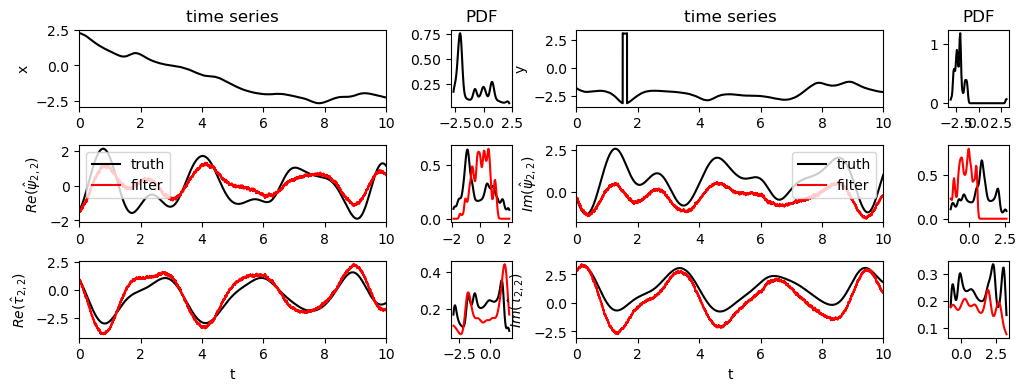

In [118]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k',label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
ax4.set_title('PDF')

samples = psi_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
ax44.set_title('PDF')

samples = psi_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')
plt.savefig('./Lagrangian_DA/LagDA_LSM_K16_L256.png',dpi=100)
plt.show()

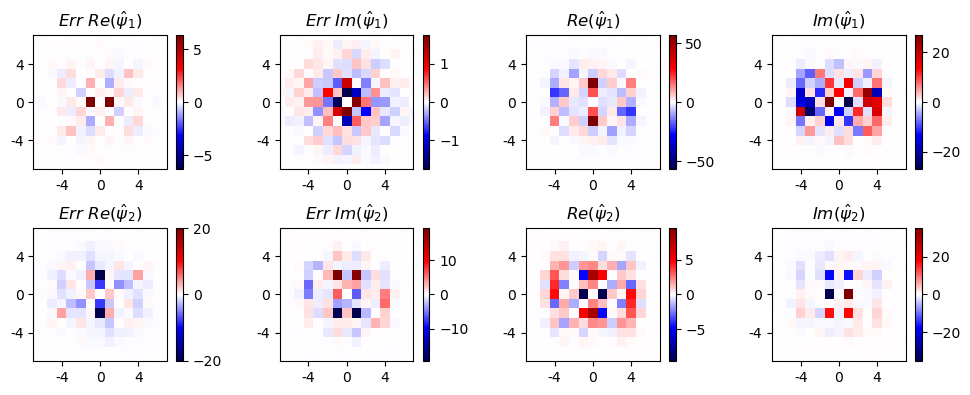

In [202]:
# plot error mode
psi_k_pos_KK = inv_truncate(np.reshape(psi_k_pos, (psi_k_pos.shape[0]**2, -1), order='F'), 7, K, style='square')
tau_k_pos_KK = inv_truncate(np.reshape(tau_k_pos, (tau_k_pos.shape[0]**2, -1), order='F'), 7, K, style='square')
psi1_k_pos_KK, psi2_k_pos_KK = eigen2layer(K,0,r1,r2,psi_k_pos_KK,tau_k_pos_KK)

fig, axs = plt.subplots(2, 4, figsize=(10,4))

dataplot = np.zeros((K,K,2,4))
dataplot[:,:,0,0] = (psi1_k_pos_KK[:, :, -1] - psi1_k_t[:, :, -1]).real
dataplot[:,:,0,1] = (psi1_k_pos_KK[:, :, -1] - psi1_k_t[:, :, -1]).imag
dataplot[:,:,0,2] = psi1_k_t[:, :, -1].real
dataplot[:,:,0,3] = psi1_k_t[:, :, -1].imag
dataplot[:,:,1,0] = (psi2_k_pos_KK[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1,1] = (psi2_k_pos_KK[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,1,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,1,3] = psi2_k_t[:, :, -1].imag

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(2):
    for j in range(4):
        n_tick = 4
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        fig.colorbar(im, ax=axs[i,j])

axs[0,0].set_title(f'$Err\ Re(\hat{{\psi}}_1)$')
axs[0,1].set_title(f'$Err\ Im(\hat{{\psi}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}_1)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}_1)$')
axs[1,0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1,1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/lsmda_err_psi_k_K16_fullQG_beta22.png', dpi=100)
plt.show()

In [198]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi1_pos = np.zeros_like(psi1_k_pos_KK)
psi2_pos = np.zeros_like(psi2_k_pos_KK)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi1_pos[:,:,i] = np.fft.ifft2(psi1_k_pos_KK[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(psi2_k_pos_KK[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-3:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi1_pos = np.real(psi1_pos)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=0)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

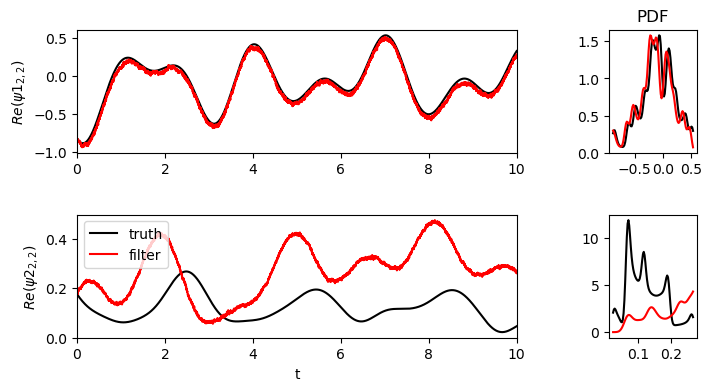

In [203]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.plot(xaxis, psi1_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k', label='truth')
samples = psi1_pos[iky, ikx, :]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'r', label='filter')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K16_fullQG_beta22_real.png',dpi=100)
plt.show()

### 1.2.2 Mode truncation 

#### 1.2.2.1 K=16

In [6]:
# truncate parameter
r_cut = 6
style = 'circle'

In [5]:
# load data of LSM
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']
# est_params = np.load('../data/est_paras_ou_K16_beta22.npy', allow_pickle=True).item()
# gamma_est = est_params['gamma']
# omega_est = est_params['omega']
# f_est = est_params['f']
# sigma_est = est_params['sigma']
obs = np.load('../data/obs_K16_beta22.npz')
xt = obs['xt']
yt = obs['yt']
ut = obs['ut']
vt = obs['vt']
sigma_xy = obs['sigma_xy']
L = obs['L']

In [7]:
# Model calibration
est_params = calibrate_OU(r1, r2, psi1_k_t, psi2_k_t, K, dt, Lag=60000, r_cut=r_cut, style=style)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.save('../data/est_paras_ou_K16_beta22_tr.npy', est_params)

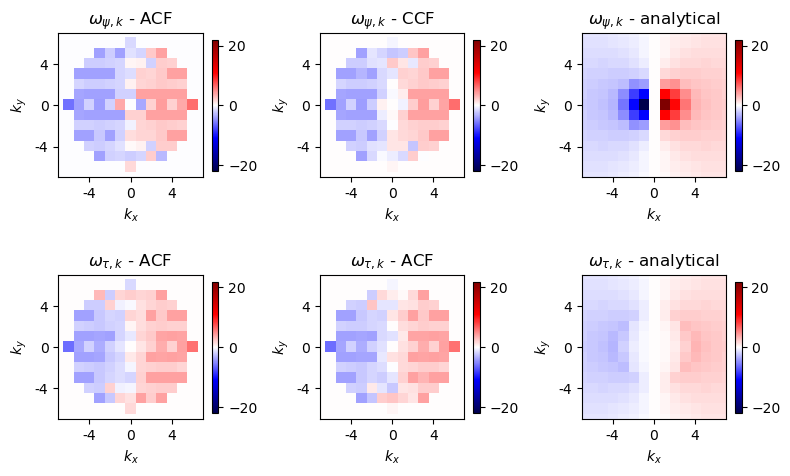

In [8]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est_ca[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est_ca[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = 7

for i in range(2):
    for j in range(3):
        n_tick = 4
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K16_beta22_tr.png', dpi=100)
plt.show()

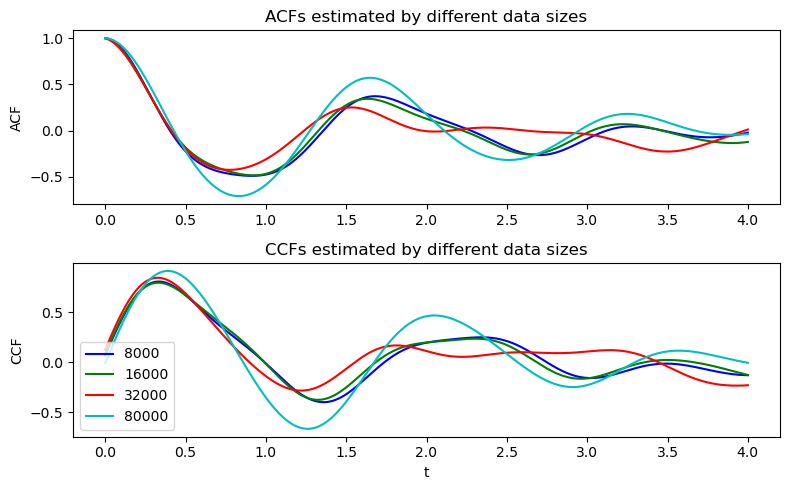

In [7]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [8000, 16000, 32000, 80000]
Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 5; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K16_beta22_tr.png')
plt.show()

In [9]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

# save data
psi_k_truth = {
    'psi_k_t': psi_k_t,
    'tau_k_t': tau_k_t,
    'r_cut': r_cut
}
np.savez('../data/psi_k_truth_K16_beta22_tr.npz', **psi_k_truth)

In [12]:
# Run OU process
# get the initial condition
N = 100000
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style)

# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_K16_beta22_tr.npz', **ou_run)

In [13]:
# ifft to real space
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k, style=style)
psi1_ifft = np.zeros((K,K,N))
psi1_ifft_t = np.zeros((K,K,N))
psi2_ifft = np.zeros((K,K,N))
psi2_ifft_t = np.zeros((K,K,N))

for i in range(N):
    psi1_ifft[:,:,i] = np.fft.ifft2(psi1_k[:, :, i])
    psi2_ifft[:,:,i] = np.fft.ifft2(psi2_k[:, :, i])
    psi1_ifft_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_ifft_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

# save data
psi_ou_truth = {
    'psi1_ifft': psi1_ifft,
    'psi1_ifft_t': psi1_ifft_t,
    'psi2_ifft': psi2_ifft,
    'psi2_ifft_t': psi2_ifft_t,
    'N': N,
    'r_cut': r_cut
}
np.savez('../data/psi_ou_truth_K16_beta22_tr.npz', **psi_ou_truth)

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_23850/2999101428.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  psi1_ifft[:,:,i] = np.fft.ifft2(psi1_k[:, :, i])
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_23850/2999101428.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  psi2_ifft[:,:,i] = np.fft.ifft2(psi2_k[:, :, i])
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_23850/2999101428.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  psi1_ifft_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_23850/2999101428.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  psi2_ifft_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])


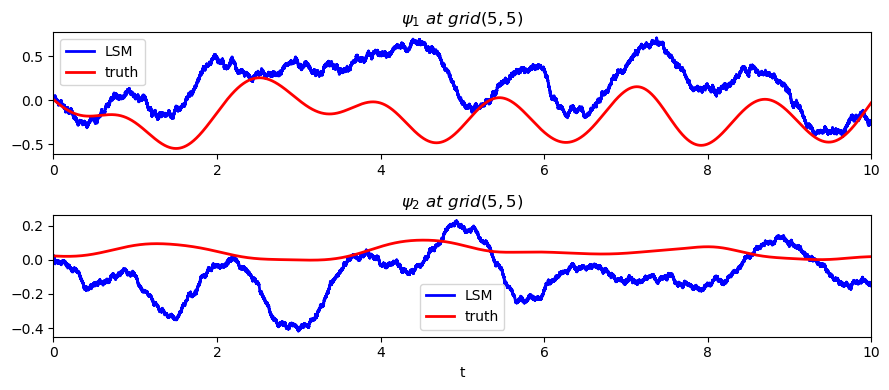

In [14]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi1_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi1_ifft_t[mode,mode,:N]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi2_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt), np.real(psi2_ifft_t[mode,mode,:N]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K16_beta22_tr.png', dpi=100)
plt.show()

In [15]:
# energy spectrum of eigenmodes
ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 10000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,N-t_avrg:N], tau_k_t[:,:,None,N-t_avrg:N]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, ie_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += ie_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

psi_hat = np.concatenate((psi_k[:,:,None,N-t_avrg:N], tau_k[:,:,None,N-t_avrg:N]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike_ou, iape_ou, iene_ou, ietp_ou, ie_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike_ou
    ape_ou += iape_ou
    ene_ou += iene_ou
    etp_ou += ietp_ou
    e_mode_ou += ie_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

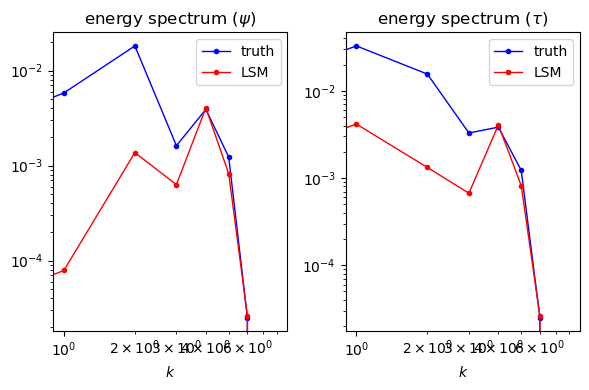

In [16]:
# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K16_beta22_tr.png', dpi=100)
plt.show()

In [17]:
# energy spectrum of layers
ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 10000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,N-t_avrg:N], psi2_k_t[:,:,None,N-t_avrg:N]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, ie_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += ie_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

# psi1_k, psi2_k = eigen2layer(K,cut,r1,r2,psi_k,tau_k)
psi_hat = np.concatenate((psi1_k[:,:,None,N-t_avrg:N], psi2_k[:,:,None,N-t_avrg:N]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike_ou, iape_ou, iene_ou, ietp_ou, ie_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike_ou
    ape_ou += iape_ou
    ene_ou += iene_ou
    etp_ou += ietp_ou
    e_mode_ou += ie_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

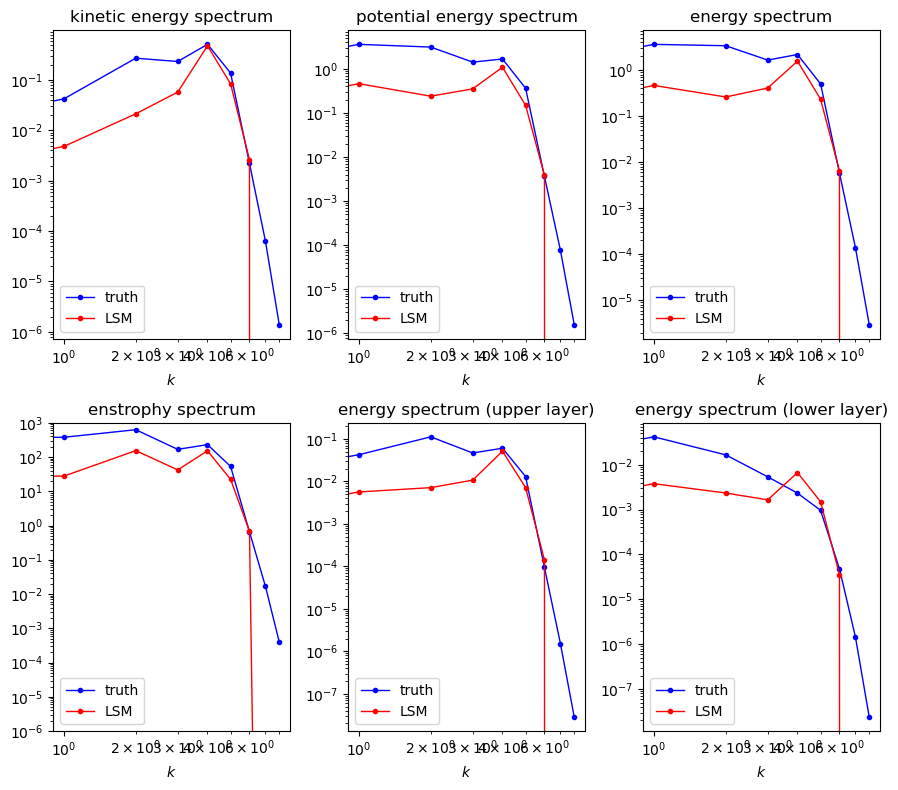

In [18]:
# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-6, 1000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K16_beta22_tr.png', dpi=100)
plt.show()

see if this gets better for K=128

In [21]:
# Lagrangian DA
N = 100000
N_chunk = 2000
lsm_da = Lagrangian_DA_OU(N, N_chunk, K, psi_k_t, tau_k_t, r1, r2, dt, sigma_xy, f_est, gamma_est, omega_est, sigma_est, xt.T, yt.T, r_cut, style)
mu_t, R_t = lsm_da.forward()

In [36]:
# reshape flattened variables to two modes matrices
def mu2psi(mu_t, K, r_cut, style):
    '''reshape flattened variables to two modes matrices'''
    mu_t_ = mu_t.reshape((mu_t.shape[0] // 2, 2, -1), order='F')
    psi_k = inv_truncate(mu_t_[:,0,:], r_cut, K, style)
    tau_k = inv_truncate(mu_t_[:,1,:], r_cut, K, style)
        
    return psi_k, tau_k

psi_k_pos, tau_k_pos = mu2psi(mu_t, K, r_cut, style)

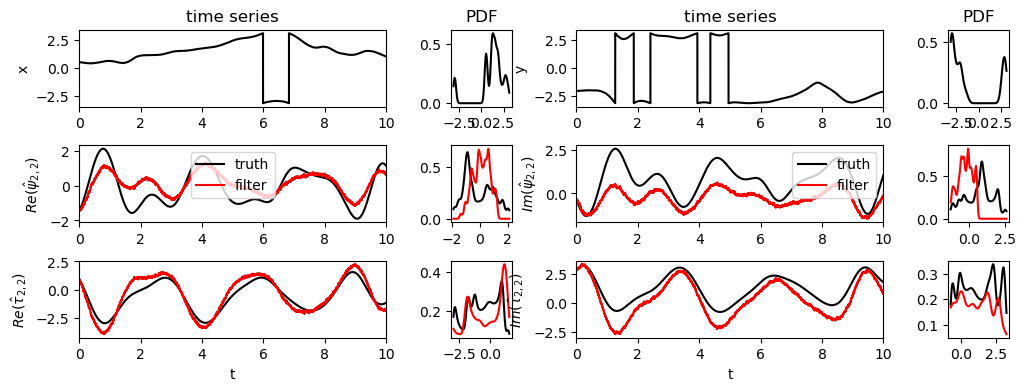

In [25]:
# Plot
sel0 = 0; sel1 = N // s_rate # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt*s_rate, sel1*dt*s_rate, interv*dt*s_rate)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k',label='x')
ax1.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax2.set_ylabel('$Re(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax3.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax3.set_ylabel(r'$Re(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
ax4.set_title('PDF')

samples = psi_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, :].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax22.set_ylabel('$Im(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax33.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax33.set_ylabel(r'$Im(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
ax44.set_title('PDF')

samples = psi_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/LagDA_LSM_K16_L256_tr.png',dpi=100)
plt.show()

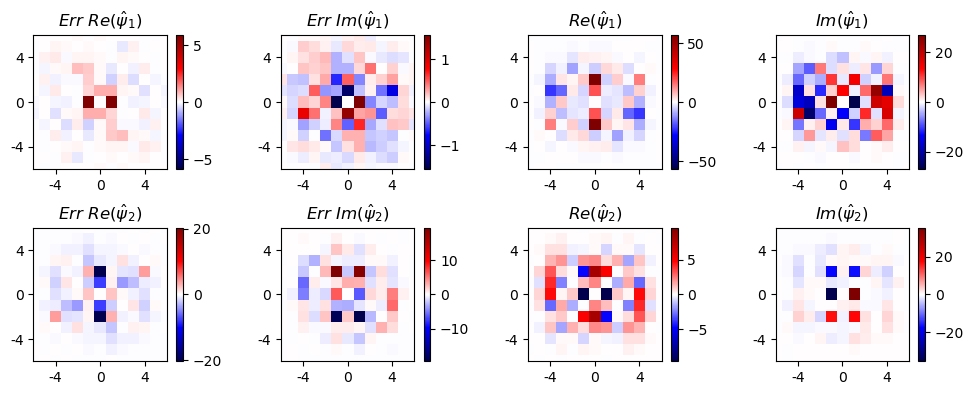

In [26]:
# plot error mode
psi1_k_pos_KK, psi2_k_pos_KK = eigen2layer(K,r_cut,r1,r2,psi_k_pos,tau_k_pos,style)

fig, axs = plt.subplots(2, 4, figsize=(10,4))

dataplot = np.zeros((K,K,2,4))
dataplot[:,:,0,0] = (psi1_k_pos_KK[:, :, -1] - psi1_k_t[:, :, -1]).real
dataplot[:,:,0,1] = (psi1_k_pos_KK[:, :, -1] - psi1_k_t[:, :, -1]).imag
dataplot[:,:,0,2] = psi1_k_t[:, :, -1].real
dataplot[:,:,0,3] = psi1_k_t[:, :, -1].imag
dataplot[:,:,1,0] = (psi2_k_pos_KK[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1,1] = (psi2_k_pos_KK[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,1,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,1,3] = psi2_k_t[:, :, -1].imag

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(2):
    for j in range(4):
        n_tick = 4
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])

axs[0,0].set_title(f'$Err\ Re(\hat{{\psi}}_1)$')
axs[0,1].set_title(f'$Err\ Im(\hat{{\psi}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}_1)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}_1)$')
axs[1,0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1,1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
# plt.savefig('./Lagrangian_DA/lsmda_err_psi_k_K16_fullQG_beta22_tr.png', dpi=100)
plt.show()

In [27]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi1_pos = np.zeros_like(psi1_k_pos_KK)
psi2_pos = np.zeros_like(psi2_k_pos_KK)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi1_pos[:,:,i] = np.fft.ifft2(psi1_k_pos_KK[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(psi2_k_pos_KK[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi1_pos = np.real(psi1_pos)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=0)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

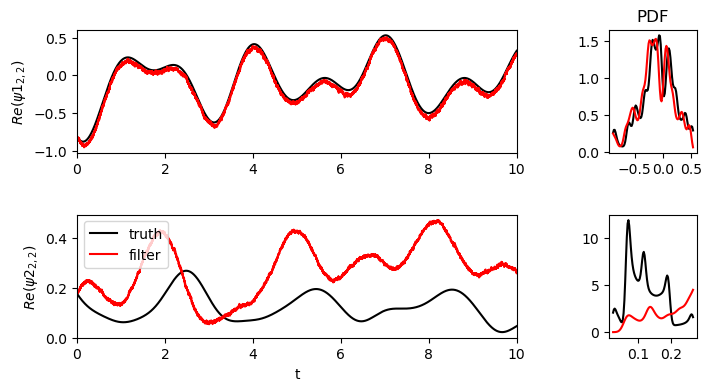

In [28]:
# Plot
sel0 = 0; sel1 = N // s_rate # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt*s_rate, sel1*dt*s_rate, interv*dt*s_rate)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.plot(xaxis, psi1_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax1.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt*s_rate, sel1*dt*s_rate)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k', label='truth')
samples = psi1_pos[iky, ikx, :]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'r', label='filter')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/LSMDA_K16_fullQG_beta22_tr_real.png',dpi=100)
plt.show()

In [30]:
# RMSE
rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(upper layer): 0.03844330292852624
RMSE(lower layer): 0.20069475144077392


#### 1.2.2.2 K=128

##### 1.2.2.2.1 $\beta=111, \nu=10^{-12}$

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-12_beta111_K128_dt5e-4_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [4]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

np.save('../data/eigens_K128_beta111.npy', eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [5]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.05
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta111.npz', **obs)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


###### $r_{cut}=12$

In [3]:
# truncate parameter
r_cut = 12
style = 'circle'

In [5]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

# save data
psi_k_truth = {
    'psi_k_t': psi_k_t,
    'tau_k_t': tau_k_t,
    'r_cut': r_cut
}
np.savez('../data/psi_k_truth_K128_beta111_tr.npz', **psi_k_truth)

In [6]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=2000, r_cut=r_cut, style=style)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.save('../data/est_paras_ou_K128_beta111_tr.npy', est_params)

/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


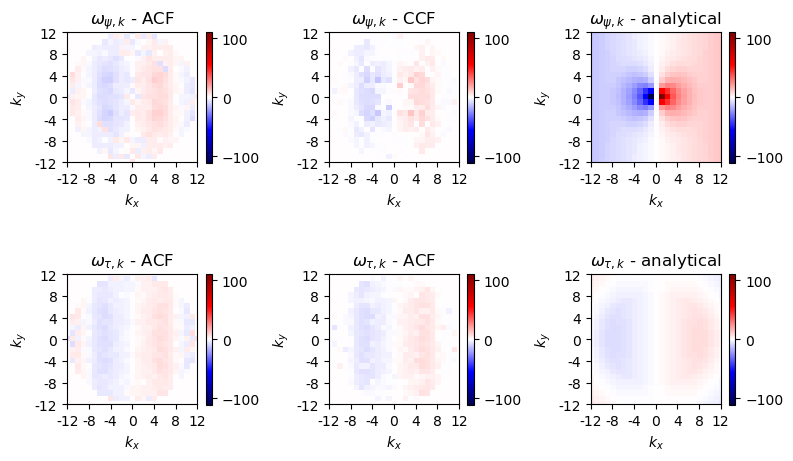

In [7]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(2):
    for j in range(3):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K128_beta111_tr.png', dpi=100)
plt.show()

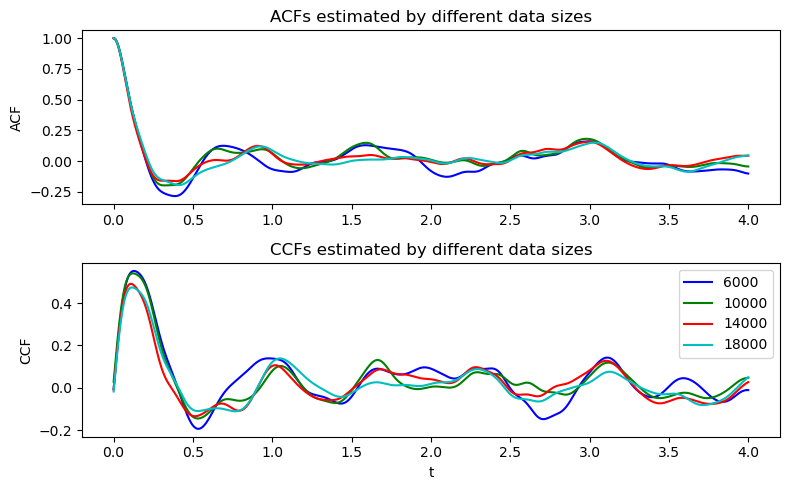

In [11]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [6000, 10000, 14000, 18000]
Lag = 2000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K128_beta111_tr.png')
plt.show()

In [12]:
# Run OU process
# get the initial condition
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate)

# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_K128_beta111_tr.npz', **ou_run)

In [4]:
# load data
ou_run = np.load('../data/ou_run_K128_beta111_tr.npz')
psi_k = ou_run['psi_k']
tau_k = ou_run['tau_k']

eigens = np.load('../data/eigens_K128_beta111.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

In [5]:
# ifft to real space
interv = 10
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)
del psi_k, tau_k
psi1_ifft = np.fft.ifft2(psi1_k[:, :, ::interv], axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k[:, :, ::interv], axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

# # save data
# psi_ou_truth = {
#     'psi1_ifft': psi1_ifft,
#     'psi1_ifft_t': psi1_ifft_t,
#     'psi2_ifft': psi2_ifft,
#     'psi2_ifft_t': psi2_ifft_t,
#     'N': N,
#     'r_cut': r_cut
# }
# np.savez('../data/psi_ou_truth_K128_beta22_tr.npz', **psi_ou_truth)

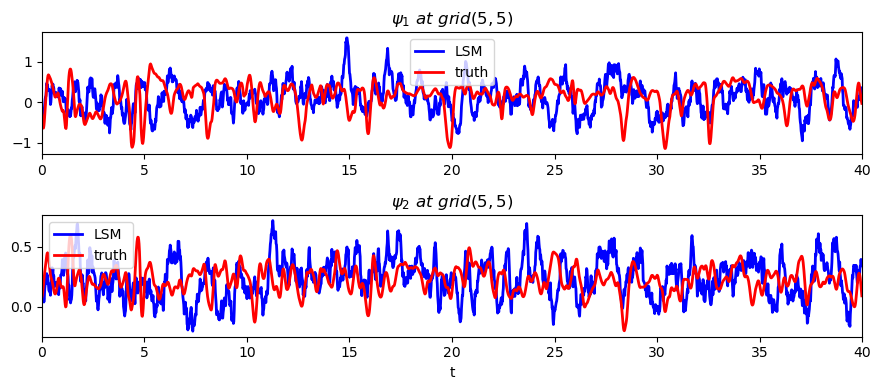

In [8]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_t[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_t[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K128_beta111_tr.png', dpi=100)
plt.show()

In [5]:
# load data
# psi_k_truth = np.load('../data/psi_k_truth_K128_beta111_tr.npz')
# psi_k_t = psi_k_truth['psi_k_t']
# tau_k_t = psi_k_truth['tau_k_t']

ou_run = np.load('../data/ou_run_K128_beta111_tr.npz')
psi_k = ou_run['psi_k']
tau_k = ou_run['tau_k']

eigens = np.load('../data/eigens_K128_beta111.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k, style=style)

In [7]:
# energy spectrum of eigenmodes
t_avrg = 8000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
del psi_k_t, tau_k_t
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
del psi_k, tau_k
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

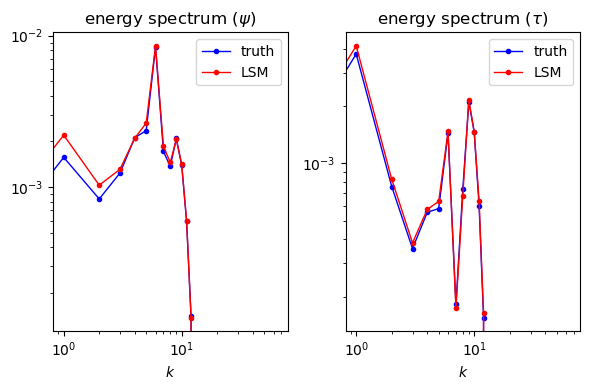

In [8]:
# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K128_beta111_tr.png', dpi=100)
plt.show()

In [6]:
# energy spectrum of layers
t_avrg = 8000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
del psi1_k_t, psi2_k_t
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

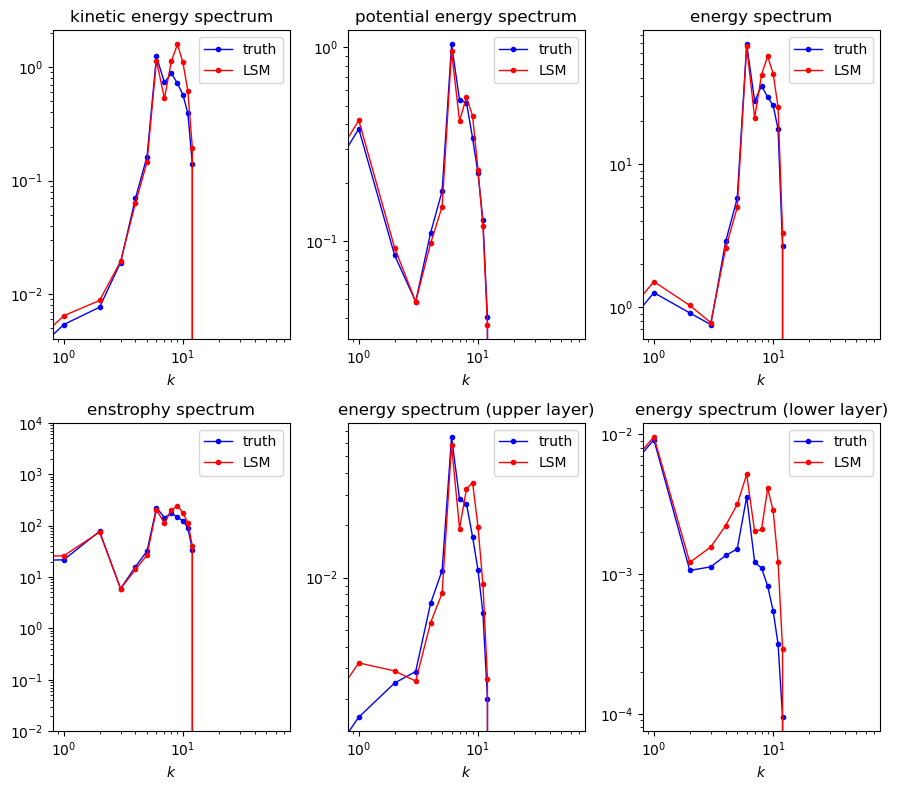

In [7]:
# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-2, 10000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K128_beta111_tr.png', dpi=100)
plt.show()

In [12]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta111.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']
est_params = np.load('../data/est_paras_ou_K128_beta111_tr.npy', allow_pickle=True).item()
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']
obs = np.load('../data/obs_K128_beta111.npz')
xt = obs['xt']
yt = obs['yt']
sigma_xy = obs['sigma_xy']
L = obs['L']
psi_k_truth = np.load('../data/psi_k_truth_K128_beta111_tr.npz')
psi_k_t = psi_k_truth['psi_k_t']
tau_k_t = psi_k_truth['tau_k_t']

In [16]:
# Lagrangian DA
N_chunk = 500
N = 80000# psi1_k_t_fine.shape[-1]
lsm_da = Lagrangian_DA_OU(N, N_chunk, K, psi_k_t, tau_k_t, r1, r2, dt, sigma_xy, f_est, gamma_est, omega_est, sigma_est, xt.T, yt.T, r_cut, style)
mu_t, R_t = lsm_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/LSMDA_pos_K128_beta111_tr.npz', **da_pos)

In [29]:
# load data
da_pos = np.load('../data/LSMDA_pos_K128_beta111_tr.npz')
mu_t = da_pos['mu_t']

In [30]:
# reshape flattened variables to two modes matrices
psi_k_pos, tau_k_pos = mu2psi(mu_t, K, r_cut, style)

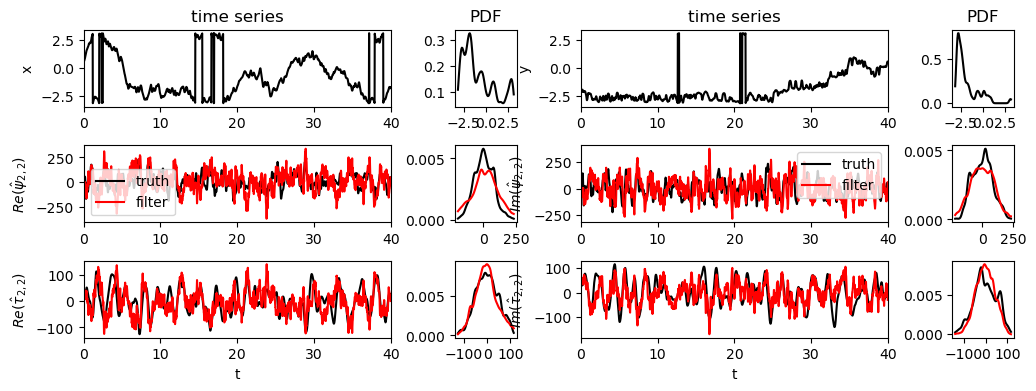

In [33]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k',label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].real, 'k', label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].real, 'k', label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax4.set_title('PDF')

samples = psi_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax5.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi_k_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax6.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = tau_k_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].imag, 'k', label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].imag, 'k', label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax44.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax44.set_title('PDF')

samples = psi_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax55.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi_k_pos[iky, ikx, sel0:sel1].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax66.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = tau_k_pos[iky, ikx, sel0:sel1].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K128_beta111_tr.png',dpi=100)
plt.show()

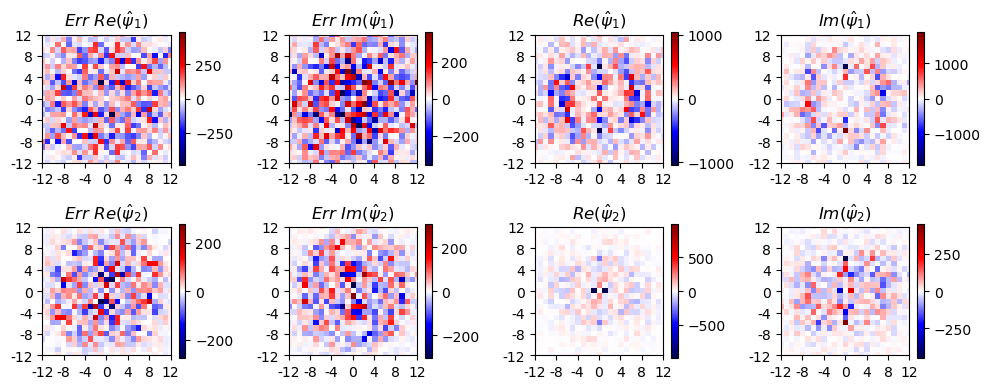

In [37]:
# plot error mode
psi1_k_pos_KK, psi2_k_pos_KK = eigen2layer(K,r_cut,r1,r2,psi_k_pos,tau_k_pos,style)

fig, axs = plt.subplots(2, 4, figsize=(10,4))

dataplot = np.zeros((K,K,2,4))
dataplot[:,:,0,0] = (psi1_k_pos_KK[:, :, N-1] - psi1_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,0,1] = (psi1_k_pos_KK[:, :, N-1] - psi1_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,0,2] = psi1_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,0,3] = psi1_k_t[:, :, N//s_rate-1].imag / K**2
dataplot[:,:,1,0] = (psi2_k_pos_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,1,1] = (psi2_k_pos_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,1,2] = psi2_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,1,3] = psi2_k_t[:, :, N//s_rate-1].imag / K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(2):
    for j in range(4):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])

axs[0,0].set_title(f'$Err\ Re(\hat{{\psi}}_1)$')
axs[0,1].set_title(f'$Err\ Im(\hat{{\psi}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}_1)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}_1)$')
axs[1,0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1,1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/LSMDA_err_psi_k_K128_beta111_tr.png', dpi=100)
plt.show()

In [25]:
# ifft to real space
interv = 10
psi1_t = np.fft.ifft2(psi1_k_t[:, :, :N//s_rate:interv], axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t[:, :, :N//s_rate:interv], axes=(0,1))
del psi1_k_t, psi2_k_t
psi1_pos = np.fft.ifft2(psi1_k_pos_KK[:, :, ::s_rate*interv], axes=(0,1))
del psi1_k_pos_KK
psi2_pos = np.fft.ifft2(psi2_k_pos_KK[:, :, ::s_rate*interv], axes=(0,1))
del psi2_k_pos_KK

# check imaginary part
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi1_pos = np.real(psi1_pos)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=0)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

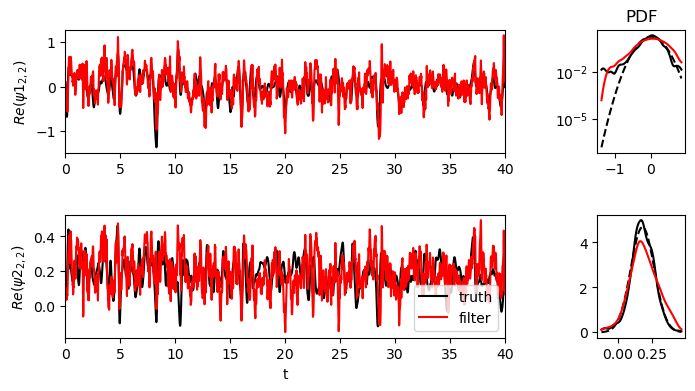

In [27]:
# Plot
sel0 = 0//(interv*s_rate); sel1 = N//(interv*s_rate) # plot time range
ikx = 2; iky = 2 # x,y to plot
xaxis = np.arange(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt, interv*s_rate*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1], 'k')
ax1.plot(xaxis, psi1_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax1.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax2.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi1_pos[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'r', label='filter')
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi2_pos[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K128_beta111_tr_real.png',dpi=100)
plt.show()

In [28]:
# RMSE
rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(upper layer): 0.24509825665150098
RMSE(lower layer): 0.12178313445036414


###### 1.2.2.2.2 $\beta=22, \nu=10^{-12}$

In [3]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-12_beta22_K128_dt5e-4_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)
# print('psi1_k_t.shape',psi1_k_t.shape)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [3]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

np.save('../data/eigens_K128_beta22.npy', eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [3]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.05
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta22.npz', **obs)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


###### $r_{cut}=12$

In [4]:
# truncate parameter
r_cut = 12
style = 'circle'

In [5]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=2000, r_cut=r_cut, style=style)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.save('../data/est_paras_ou_K128_beta22_tr.npy', est_params)

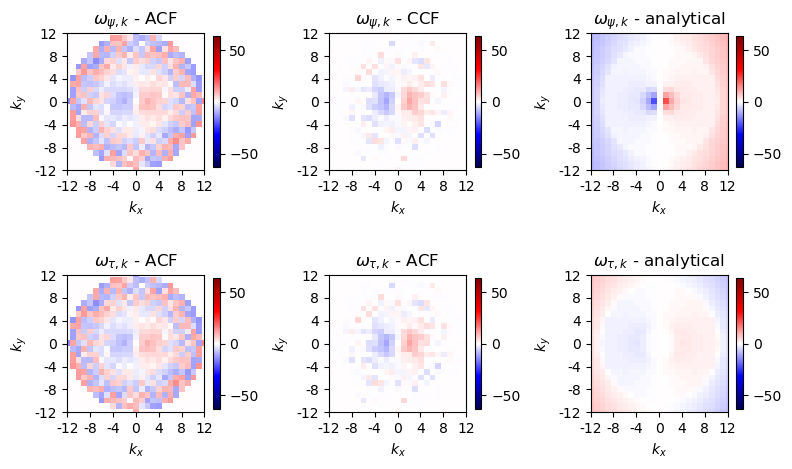

In [37]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(2):
    for j in range(3):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K128_beta22_tr.png', dpi=100)
plt.show()

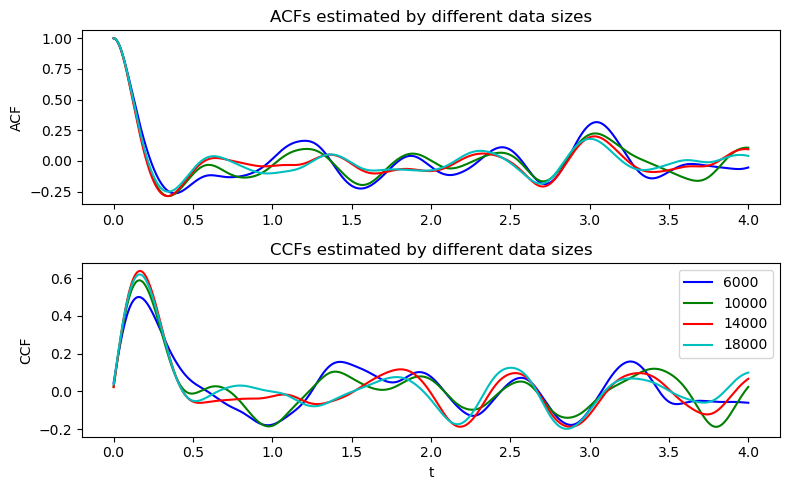

In [9]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [6000, 10000, 14000, 18000]
Lag = 2000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K128_beta22_tr.png')
plt.show()

In [6]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

# save data
psi_k_truth = {
    'psi_k_t': psi_k_t,
    'tau_k_t': tau_k_t,
    'r_cut': r_cut
}
np.savez('../data/psi_k_truth_K128_beta22_tr.npz', **psi_k_truth)

In [12]:
# Run OU process
# get the initial condition
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate)

# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_K128_beta22_tr.npz', **ou_run)

In [5]:
# ifft to real space
interv = 10
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)
del psi_k, tau_k
psi1_ifft = np.fft.ifft2(psi1_k[:, :, ::interv], axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k[:, :, ::interv], axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

# # save data
# psi_ou_truth = {
#     'psi1_ifft': psi1_ifft,
#     'psi1_ifft_t': psi1_ifft_t,
#     'psi2_ifft': psi2_ifft,
#     'psi2_ifft_t': psi2_ifft_t,
#     'N': N,
#     'r_cut': r_cut
# }
# np.savez('../data/psi_ou_truth_K128_beta22_tr.npz', **psi_ou_truth)

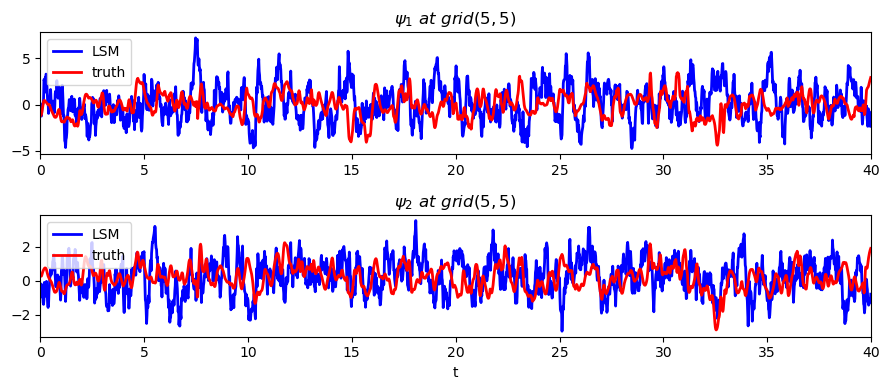

In [8]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_t[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_t[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K128_beta22_tr.png', dpi=100)
plt.show()

In [5]:
# load data
psi_k_truth = np.load('../data/psi_k_truth_K128_beta22_tr.npz')
psi_k_t = psi_k_truth['psi_k_t']
tau_k_t = psi_k_truth['tau_k_t']

ou_run = np.load('../data/ou_run_K128_beta22_tr.npz')
psi_k = ou_run['psi_k']
tau_k = ou_run['tau_k']
del ou_run

eigens = np.load('../data/eigens_K128_beta22.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k, style=style)

In [6]:
# energy spectrum of eigenmodes
t_avrg = 8000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
del psi_k_t, tau_k_t
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
del psi_k, tau_k
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

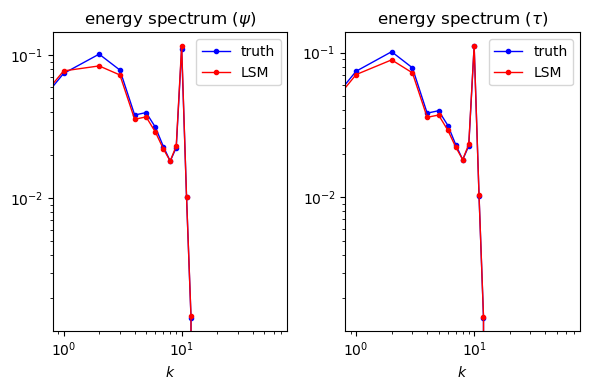

In [7]:
# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K128_beta22_tr.png', dpi=100)
plt.show()

In [9]:
# energy spectrum of layers
t_avrg = 8000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
del psi1_k_t, psi2_k_t
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

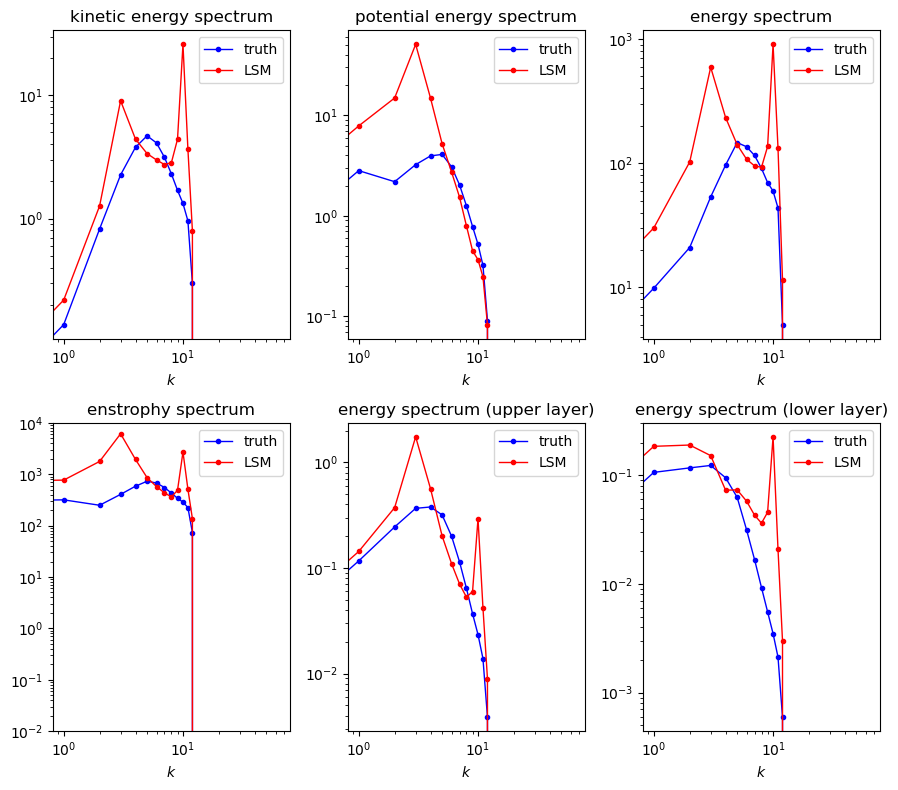

In [10]:
# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-2, 10000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K128_beta22_tr.png', dpi=100)
plt.show()

In [21]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta22.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']
est_params = np.load('../data/est_paras_ou_K128_beta22_tr.npy', allow_pickle=True).item()
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']
obs = np.load('../data/obs_K128_beta22.npz')
xt = obs['xt']
yt = obs['yt']
sigma_xy = obs['sigma_xy']
L = obs['L']
psi_k_truth = np.load('../data/psi_k_truth_K128_beta22_tr.npz')
psi_k_t = psi_k_truth['psi_k_t']
tau_k_t = psi_k_truth['tau_k_t']

In [9]:
# Lagrangian DA
N_chunk = 500
N = 80000# psi1_k_t_fine.shape[-1]
lsm_da = Lagrangian_DA_OU(N, N_chunk, K, psi_k_t, tau_k_t, r1, r2, dt, sigma_xy, f_est, gamma_est, omega_est, sigma_est, xt.T, yt.T, r_cut, style)
mu_t, R_t = lsm_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/LSMDA_pos_K128_beta22_tr.npz', **da_pos)

In [5]:
# load data
da_pos = np.load('../data/LSMDA_pos_K128_beta22_tr.npz')
mu_t = da_pos['mu_t']

In [6]:
# reshape flattened variables to two modes matrices
psi_k_pos, tau_k_pos = mu2psi(mu_t, K, r_cut, style)

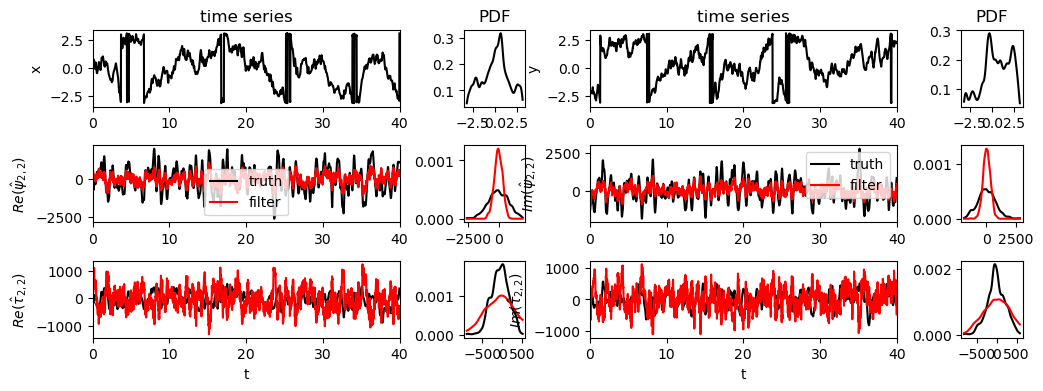

In [24]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k',label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].real, 'k', label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].real, 'k', label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax4.set_title('PDF')

samples = psi_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax5.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi_k_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax6.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = tau_k_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].imag, 'k', label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].imag, 'k', label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax44.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax44.set_title('PDF')

samples = psi_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax55.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi_k_pos[iky, ikx, sel0:sel1].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax66.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = tau_k_pos[iky, ikx, sel0:sel1].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K128_beta22_tr.png',dpi=100)
plt.show()

In [ ]:
# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].real / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
ax4.set_yscale('log', base=10) 
ax4.set_ylim(1e-2, np.max(p))

ax11.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k', label='truth')
ax22.plot(xaxis, mu_t[ik_,sel0:sel1:interv].imag / K**2, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax33.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax33.set_yscale('log', base=10) 
ax33.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax44.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].imag / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
ax44.set_yscale('log', base=10) 


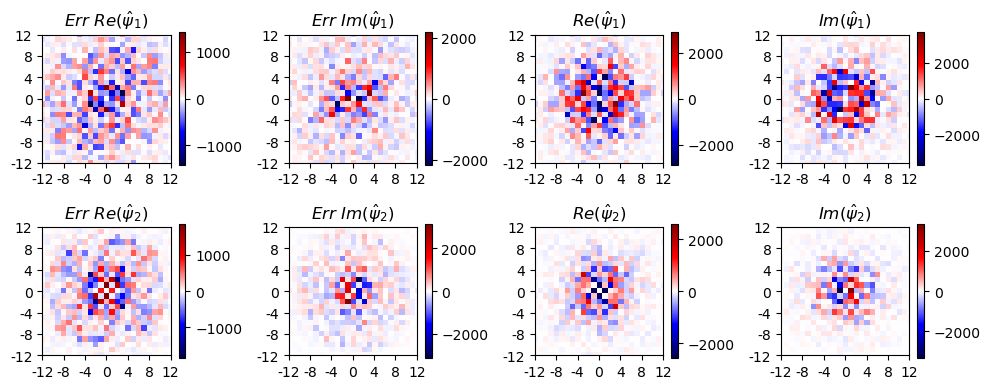

In [27]:
# plot error mode
psi1_k_pos_KK, psi2_k_pos_KK = eigen2layer(K,r_cut,r1,r2,psi_k_pos,tau_k_pos,style)

fig, axs = plt.subplots(2, 4, figsize=(10,4))

dataplot = np.zeros((K,K,2,4))
dataplot[:,:,0,0] = (psi1_k_pos_KK[:, :, N-1] - psi1_k_t[:, :, N//s_rate-1]).real/ K**2
dataplot[:,:,0,1] = (psi1_k_pos_KK[:, :, N-1] - psi1_k_t[:, :, N//s_rate-1]).imag/ K**2
dataplot[:,:,0,2] = psi1_k_t[:, :, N//s_rate-1].real/ K**2
dataplot[:,:,0,3] = psi1_k_t[:, :, N//s_rate-1].imag/ K**2
dataplot[:,:,1,0] = (psi2_k_pos_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).real/ K**2
dataplot[:,:,1,1] = (psi2_k_pos_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).imag/ K**2
dataplot[:,:,1,2] = psi2_k_t[:, :, N//s_rate-1].real/ K**2
dataplot[:,:,1,3] = psi2_k_t[:, :, N//s_rate-1].imag/ K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(2):
    for j in range(4):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])

axs[0,0].set_title(f'$Err\ Re(\hat{{\psi}}_1)$')
axs[0,1].set_title(f'$Err\ Im(\hat{{\psi}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}_1)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}_1)$')
axs[1,0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1,1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/LSMDA_err_psi_k_K128_beta22_tr.png', dpi=100)
plt.show()

In [9]:
# ifft to real space
interv = 10
psi1_t = np.fft.ifft2(psi1_k_t[:, :, :N//s_rate:interv], axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t[:, :, :N//s_rate:interv], axes=(0,1))
del psi1_k_t, psi2_k_t
psi1_pos = np.fft.ifft2(psi1_k_pos_KK[:, :, ::s_rate*interv], axes=(0,1))
del psi1_k_pos_KK
psi2_pos = np.fft.ifft2(psi2_k_pos_KK[:, :, ::s_rate*interv], axes=(0,1))
del psi2_k_pos_KK

# check imaginary part
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi1_pos = np.real(psi1_pos)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=0)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

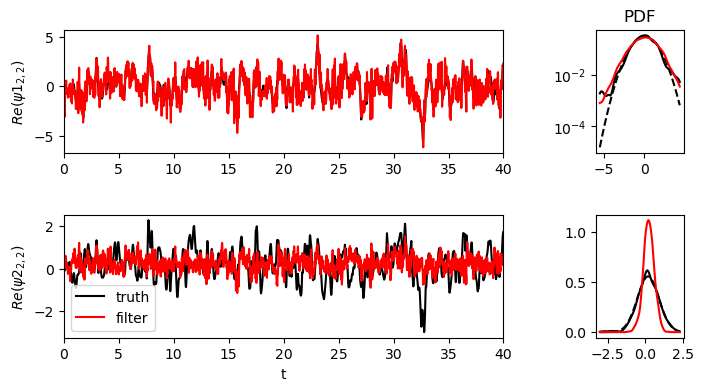

In [10]:
# Plot
sel0 = 0//(interv*s_rate); sel1 = N//(interv*s_rate) # plot time range
ikx = 2; iky = 2 # x,y to plot
xaxis = np.arange(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt, interv*s_rate*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1], 'k')
ax1.plot(xaxis, psi1_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax1.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax2.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi1_pos[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'r', label='filter')
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi2_pos[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K128_beta22_tr_real.png',dpi=100)
plt.show()

In [11]:
# RMSE
rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(upper layer): 0.756489336961804
RMSE(lower layer): 0.7327916338786478


##### 1.2.2.2.3 $\beta=3, \nu=10^{-12}$

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-12_beta3_K128_dt5e-4_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
#     psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
# print('psi1_k_t.shape',psi1_k_t.shape)
# psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
# psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>


In [3]:
# Compute eigenvalues and eigenvectors
eigens = solve_eigen(K, beta, kd, U)
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

np.save('../data/eigens_K128_beta3.npy', eigens)
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [4]:
# run obs model
L = 256 # number of tracers
K = psi1_k_t.shape[0]
N = psi1_k_t_fine.shape[-1]
sigma_xy = 0.05
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)

# run model
model = Lagrange_tracer_model(N, L, K, psi1_k_t_fine, dt, sigma_xy, x0, y0, interv=8, t_interv=40000, style='square')
xt, yt, ut, vt = model.forward()   

# save data
obs = {
    'xt': xt,
    'yt': yt,
    'ut': ut,
    'vt': vt,
    'sigma_xy': sigma_xy,
    'L': L,
    'dt': dt
}
np.savez('../data/obs_K128_beta3.npz', **obs)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_tracer.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


Sigma_xy=0.05 blows up for beta=3.

###### $r_{cut}=12$

In [3]:
# truncate parameter
r_cut = 12
style = 'circle'

In [7]:
# Truth of eigenmodes
psi_k_t, tau_k_t = layer2eigen(K, r_cut, r1, r2, psi1_k_t, psi2_k_t, style=style)

# save data
psi_k_truth = {
    'psi_k_t': psi_k_t,
    'tau_k_t': tau_k_t,
    'r_cut': r_cut
}
np.savez('../data/psi_k_truth_K128_beta3_tr.npz', **psi_k_truth)

In [8]:
# Model calibration
est_params = calibrate_OU(r1, psi_k_t, tau_k_t, K, dt*s_rate, Lag=2000, r_cut=r_cut, style=style)
gamma_est = est_params['gamma']
omega_est_ccf = est_params['omega_ccf']
omega_est_acf = est_params['omega_acf']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']

np.save('../data/est_paras_ou_K128_beta3_tr.npy', est_params)

/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


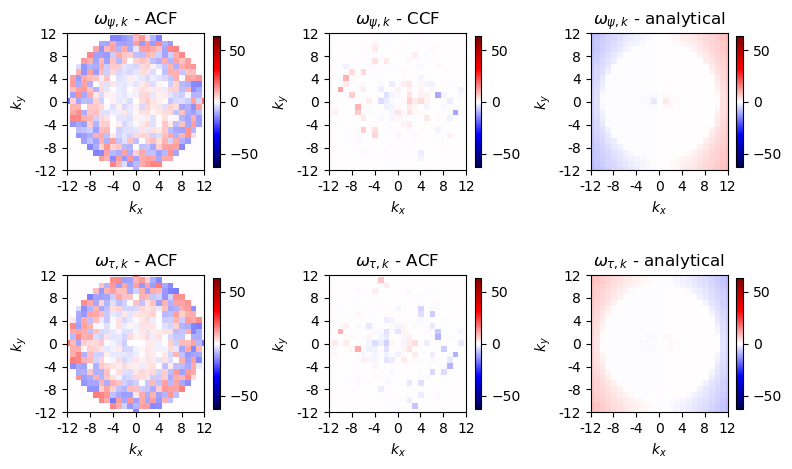

In [9]:
# Plot modes of omega
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(8,5))

dataplot = np.zeros((K,K,nrow, ncol))
dataplot[:,:,0,0] = omega_est[:,:,0]
dataplot[:,:,0,1] = omega_est_ccf[:,:,0]
dataplot[:,:,0,2] = omega1.real
dataplot[:,:,1,0] = omega_est[:,:,1]
dataplot[:,:,1,1] = omega_est_ccf[:,:,1]
dataplot[:,:,1,2] = omega2.real

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 
r = r_cut

for i in range(2):
    for j in range(3):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, 0, 2]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r, K//2+r) 
        axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k_x$')
        axs[i,j].set_ylabel('$k_y$')
        fig.colorbar(im, ax=axs[i,j], shrink=0.7)

axs[0,0].set_title(r'$\omega_{\psi,k}$ - ACF')
axs[0,1].set_title(r'$\omega_{\psi,k}$ - CCF')
axs[0,2].set_title(r'$\omega_{\psi,k}$ - analytical')
axs[1,0].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,1].set_title(r'$\omega_{\tau,k}$ - ACF')
axs[1,2].set_title(r'$\omega_{\tau,k}$ - analytical')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/omega_compare_K128_beta3_tr.png', dpi=100)
plt.show()

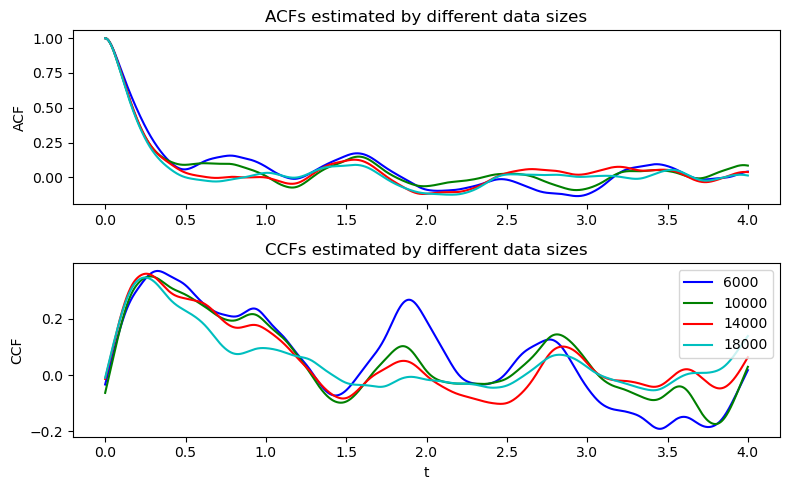

In [10]:
# Vary the amount of data used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [6000, 10000, 14000, 18000]
Lag = 2000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt*s_rate, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 3; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_k_t[:,:,:num+Lag], psi2_k_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)
colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num}' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])
plt.ylabel('ACF')
plt.title('ACFs estimated by different data sizes')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])
plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs estimated by different data sizes')
plt.legend()
plt.tight_layout()
plt.savefig('./Lagrangian_DA/acf_ccf_diffN_K128_beta3_tr.png')
plt.show()

In [11]:
# Run OU process
# get the initial condition
psi_k0 = psi_k_t[:,:,0]
tau_k0 = tau_k_t[:,:,0]
psi_k, tau_k = run_OU(psi_k0, tau_k0, K, N, dt, r_cut, r1, r2, gamma_est, omega_est, f_est, sigma_est, style=style, s_rate=s_rate)

# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'r_cut':r_cut,
    'dt': dt
}
np.savez('../data/ou_run_K128_beta3_tr.npz', **ou_run)

In [7]:
# ifft to real space
interv = 10
psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k,style)
del psi_k, tau_k
psi1_ifft = np.fft.ifft2(psi1_k[:, :, ::interv], axes=(0,1))
psi1_ifft_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_ifft = np.fft.ifft2(psi2_k[:, :, ::interv], axes=(0,1))
psi2_ifft_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))

psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft = np.roll(psi1_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft = np.roll(psi2_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi1_ifft_t = np.roll(psi1_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
psi2_ifft_t = np.roll(psi2_ifft_t, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

# # save data
# psi_ou_truth = {
#     'psi1_ifft': psi1_ifft,
#     'psi1_ifft_t': psi1_ifft_t,
#     'psi2_ifft': psi2_ifft,
#     'psi2_ifft_t': psi2_ifft_t,
#     'N': N,
#     'r_cut': r_cut
# }
# np.savez('../data/psi_ou_truth_K128_beta22_tr.npz', **psi_ou_truth)

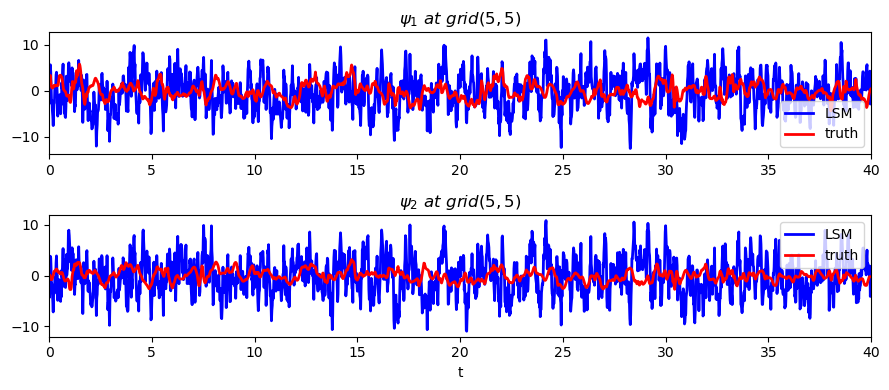

In [10]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(9, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi1_ifft_t[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_1\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.xlim(0,N*dt)
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft[mode,mode,:]), 'b', linewidth=2, label='LSM')
plt.plot(np.arange(0, (N)*dt, dt*s_rate*interv), np.real(psi2_ifft_t[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\psi_2\ at\ grid({{{:d},{:d}}})$'.format(mode, mode))
plt.legend()
plt.xlabel('t')
plt.xlim(0,N*dt)
plt.tight_layout()
plt.savefig('./LSM/psi_layer_ou_truth_K128_beta3_tr.png', dpi=100)
plt.show()

In [4]:
# load data
# psi_k_truth = np.load('../data/psi_k_truth_K128_beta3_tr.npz')
# psi_k_t = psi_k_truth['psi_k_t']
# tau_k_t = psi_k_truth['tau_k_t']

ou_run = np.load('../data/ou_run_K128_beta3_tr.npz')
psi_k = ou_run['psi_k']
tau_k = ou_run['tau_k']

eigens = np.load('../data/eigens_K128_beta3.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']

psi1_k, psi2_k = eigen2layer(K,r_cut,r1,r2,psi_k,tau_k, style=style)

In [5]:
# energy spectrum of eigenmodes
t_avrg = 8000
psi_hat_t = np.concatenate((psi_k_t[:,:,None,-t_avrg:], tau_k_t[:,:,None,-t_avrg:]), axis=2)
del psi_k_t, tau_k_t
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
del psi_k, tau_k
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

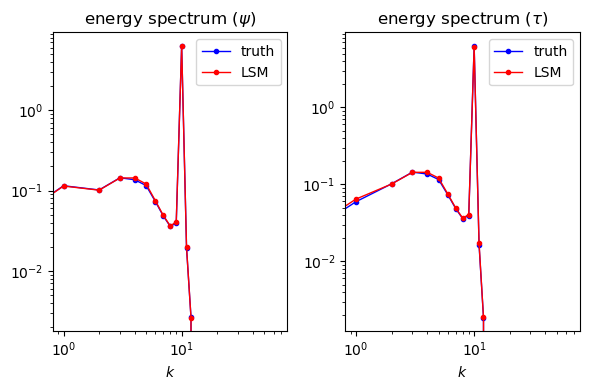

In [6]:
# Plot spectrum
nrow = 1; ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6,4))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = e_mode[:,0]
dataplot[:,1,0,0] = e_mode_ou[:,0]
dataplot[:,0,0,1] = e_mode[:,1]
dataplot[:,1,0,1] = e_mode_ou[:,1]

for i in range(2):
    n_tick = 4
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,0,0,i], '.-b', linewidth=1, label='truth')
    axs[i].loglog(np.arange(0, K//2 + 1), dataplot[:,1,0,i], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
    axs[i].set_xlabel('$k$')
    axs[i].legend()

axs[0].set_title(r'energy spectrum ($\psi$)')
axs[1].set_title(r'energy spectrum ($\tau$)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_eigen_K128_beta3_tr.png', dpi=100)
plt.show()

In [6]:
# energy spectrum of layers
t_avrg = 8000
psi_hat_t = np.concatenate((psi1_k_t[:,:,None,-t_avrg:], psi2_k_t[:,:,None,-t_avrg:]), axis=2)
del psi1_k_t, psi2_k_t
ke, ape, ene, etp, e_mode = ene_spectrum(np.transpose(psi_hat_t, axes=(3,0,1,2)), K, kd, topo, r_cut)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(np.transpose(psi_hat, axes=(3,0,1,2)), K, kd, topo, r_cut)

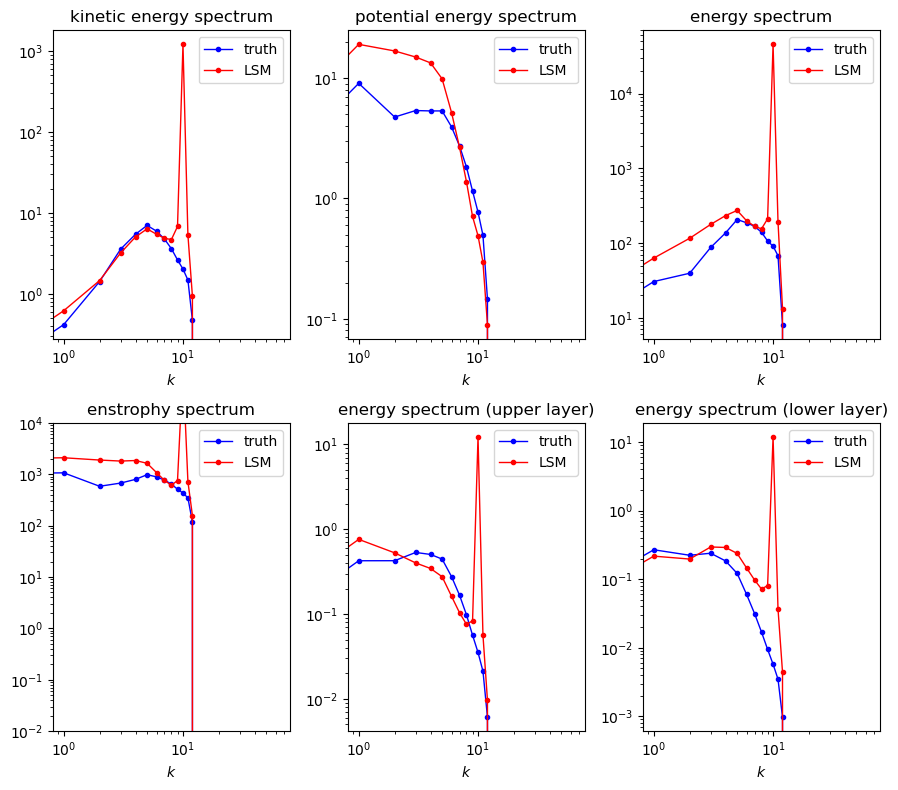

In [8]:
# Plot spectrum
nrow = 2; ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(9,8))

dataplot = np.zeros((K//2 + 1, 2, nrow, ncol))
dataplot[:,0,0,0] = ke
dataplot[:,1,0,0] = ke_ou
dataplot[:,0,0,1] = ape
dataplot[:,1,0,1] = ape_ou
dataplot[:,0,0,2] = ene
dataplot[:,1,0,2] = ene_ou
dataplot[:,0,1,0] = etp
dataplot[:,1,1,0] = etp_ou
dataplot[:,0,1,1] = e_mode[:,0]
dataplot[:,1,1,1] = e_mode_ou[:,0]
dataplot[:,0,1,2] = e_mode[:,1]
dataplot[:,1,1,2] = e_mode_ou[:,1]

for i in range(2):
    for j in range(3):
        n_tick = 4
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,0,i,j], '.-b', linewidth=1, label='truth')
        axs[i,j].loglog(np.arange(0, K//2 + 1), dataplot[:,1,i,j], '.-r', linewidth=1, label='LSM')
#         axs[i,j].set_ylim(K//2-r, K//2+r)
        axs[i,j].set_xlabel('$k$')
        axs[i,j].legend()

# axs[0,0].set_ylim(1e-5, 10)
axs[1,0].set_ylim(1e-2, 10000)

axs[0,0].set_title('kinetic energy spectrum')
axs[0,1].set_title('potential energy spectrum')
axs[0,2].set_title('energy spectrum')
axs[1,0].set_title('enstrophy spectrum')
axs[1,1].set_title(r'energy spectrum (upper layer)')
axs[1,2].set_title(r'energy spectrum (lower layer)')

plt.tight_layout()
plt.savefig('./LSM/spectrum_layer_K128_beta3_tr.png', dpi=100)
plt.show()

The cross term is significant here for $\beta=3$

In [9]:
# load data of LSM
eigens = np.load('../data/eigens_K128_beta3.npy', allow_pickle=True).item()
omega1 = eigens['omega1']
omega2 = eigens['omega2']
r1 = eigens['r1']
r2 = eigens['r2']
est_params = np.load('../data/est_paras_ou_K128_beta3_tr.npy', allow_pickle=True).item()
gamma_est = est_params['gamma']
omega_est = est_params['omega']
f_est = est_params['f']
sigma_est = est_params['sigma']
obs = np.load('../data/obs_K128_beta3.npz')
xt = obs['xt']
yt = obs['yt']
sigma_xy = obs['sigma_xy']
L = obs['L']
psi_k_truth = np.load('../data/psi_k_truth_K128_beta3_tr.npz')
psi_k_t = psi_k_truth['psi_k_t']
tau_k_t = psi_k_truth['tau_k_t']

In [12]:
# Lagrangian DA
N_chunk = 800
N = 80000# psi1_k_t_fine.shape[-1]
lsm_da = Lagrangian_DA_OU(N, N_chunk, K, psi_k_t, tau_k_t, r1, r2, dt, sigma_xy, f_est, gamma_est, omega_est, sigma_est, xt.T, yt.T, r_cut, style)
mu_t, R_t = lsm_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/LSMDA_pos_K128_beta3_tr.npz', **da_pos)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:131: RuntimeWarning: overflow encountered in matmul
  mu = mu0 + (a0 + a1 @ mu0) * dt + R0_A1_H * InvBoB @ (np.hstack((x_diff, y_diff)) - A1 @ mu0 * dt)
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:131: RuntimeWarning: invalid value encountered in matmul
  mu = mu0 + (a0 + a1 @ mu0) * dt + R0_A1_H * InvBoB @ (np.hstack((x_diff, y_diff)) - A1 @ mu0 * dt)
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:132: RuntimeWarning: overflow encountered in matmul
  R = R0 + (a1_diag[:,None] * R0 + R0 * a1_diag.conj() + np.diag(Sigma_u_diag2) - R0_A1_H * InvBoB @ R0_A1_H.conj().T) * dt
/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:132: RuntimeWarning: invalid value encountered in matmul
  R = R0 + (a1_diag[:,None] * R0 + R0 * a1_diag.conj() + np.diag(Sigma_u_diag2) - R0_A1_H * InvBoB @ R0_A1_H.conj().T) * dt


In [4]:
# load data
da_pos = np.load('../data/LSMDA_pos_K128_beta3_tr.npz')
mu_t = da_pos['mu_t']

In [5]:
# reshape flattened variables to two modes matrices
psi_k_pos, tau_k_pos = mu2psi(mu_t, K, r_cut, style)

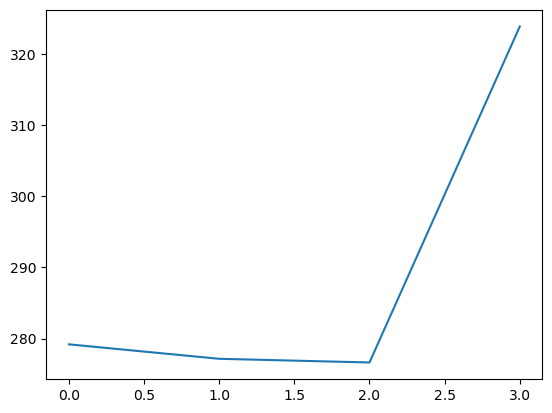

In [10]:
plt.plot(psi_k_pos[2,2,:4])

In [ ]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,4))
widths = [5, 1, 5, 1]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[2, 2])
ax44 = fig.add_subplot(spec[0, 3])
ax55 = fig.add_subplot(spec[1, 3])
ax66 = fig.add_subplot(spec[2, 3])

# plot time series
ax1.plot(xaxis, xt[0,sel0:sel1:interv], 'k',label='x')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('x')
ax1.set_title('time series')

ax2.plot(xaxis, psi_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].real, 'k', label='truth')
ax2.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel('$Re(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.legend()

ax3.plot(xaxis, tau_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].real, 'k', label='truth')
ax3.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_ylabel(r'$Re(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax3.set_xlabel('t')

# plot pdf
samples = xt[0, :]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k')
ax4.set_title('PDF')

samples = psi_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax5.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax6.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, yt[0,sel0:sel1:interv], 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('y')
ax11.set_title('time series')

ax22.plot(xaxis, psi_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].imag, 'k', label='truth')
ax22.plot(xaxis, psi_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel('$Im(\hat{{\psi}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.legend()

ax33.plot(xaxis, tau_k_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate].imag, 'k', label='truth')
ax33.plot(xaxis, tau_k_pos[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax33.set_xlim(sel0*dt, sel1*dt)
ax33.set_ylabel(r'$Im(\hat{{\tau}}_{{{:d},{:d}}})$'.format(ikx, iky))
ax33.set_xlabel('t')

# plot pdf
samples = yt[0, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k')
ax44.set_title('PDF')

samples = psi_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'k', label='truth')
samples = psi_k_pos[iky, ikx, sel0:sel1].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax55.plot(xticks, p, 'r', label='filter')

samples = tau_k_t[iky, ikx, sel0//s_rate:sel1//s_rate].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'k', label='truth')
samples = tau_k_pos[iky, ikx, sel0:sel1].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax66.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K128_beta3_tr.png',dpi=100)
plt.show()

In [ ]:
# plot error mode
psi1_k_pos_KK, psi2_k_pos_KK = eigen2layer(K,r_cut,r1,r2,psi_k_pos,tau_k_pos,style)

fig, axs = plt.subplots(2, 4, figsize=(10,4))

dataplot = np.zeros((K,K,2,4))
dataplot[:,:,0,0] = (psi1_k_pos_KK[:, :, N-1] - psi1_k_t[:, :, N//s_rate-1]).real
dataplot[:,:,0,1] = (psi1_k_pos_KK[:, :, N-1] - psi1_k_t[:, :, N//s_rate-1]).imag
dataplot[:,:,0,2] = psi1_k_t[:, :, N//s_rate-1].real
dataplot[:,:,0,3] = psi1_k_t[:, :, N//s_rate-1].imag
dataplot[:,:,1,0] = (psi2_k_pos_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).real
dataplot[:,:,1,1] = (psi2_k_pos_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).imag
dataplot[:,:,1,2] = psi2_k_t[:, :, N//s_rate-1].real
dataplot[:,:,1,3] = psi2_k_t[:, :, N//s_rate-1].imag

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx = np.fft.fftfreq(K) * K
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

for i in range(2):
    for j in range(4):
        n_tick = K//8*2
        maxabs = np.max(abs(dataplot[:, :, i, j]))
        im = axs[i,j].imshow(dataplot[:, :, i, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
        axs[i,j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False)) 
        axs[i,j].set_xticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))
        axs[i,j].set_yticklabels(Kx[::K//n_tick].astype(int))
        axs[i,j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
        axs[i,j].set_xlim(K//2-r_cut, K//2+r_cut) 
        axs[i,j].set_ylim(K//2-r_cut, K//2+r_cut)
        fig.colorbar(im, ax=axs[i,j])

axs[0,0].set_title(f'$Err\ Re(\hat{{\psi}}_1)$')
axs[0,1].set_title(f'$Err\ Im(\hat{{\psi}}_1)$')
axs[0,2].set_title(f'$Re(\hat{{\psi}}_1)$')
axs[0,3].set_title(f'$Im(\hat{{\psi}}_1)$')
axs[1,0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1,1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[1,2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[1,3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/LSMDA_err_psi_k_K128_beta3_tr.png', dpi=100)
plt.show()

In [9]:
# ifft to real space
interv = 10
psi1_t = np.fft.ifft2(psi1_k_t[:, :, :N//s_rate:interv], axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t[:, :, :N//s_rate:interv], axes=(0,1))
del psi1_k_t, psi2_k_t
psi1_pos = np.fft.ifft2(psi1_k_pos_KK[:, :, ::s_rate*interv], axes=(0,1))
del psi1_k_pos_KK
psi2_pos = np.fft.ifft2(psi2_k_pos_KK[:, :, ::s_rate*interv], axes=(0,1))
del psi2_k_pos_KK

# check imaginary part
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi1_pos = np.real(psi1_pos)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=0)
psi1_pos = np.roll(psi1_pos, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

In [ ]:
# Plot
sel0 = 0//(interv*s_rate); sel1 = N//(interv*s_rate) # plot time range
ikx = 2; iky = 2 # x,y to plot
xaxis = np.arange(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt, interv*s_rate*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1], 'k')
ax1.plot(xaxis, psi1_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax1.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax2.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi1_pos[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'r', label='filter')
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi2_pos[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/LSMDA_K128_beta3_tr_real.png',dpi=100)
plt.show()

In [ ]:
# RMSE
rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

# 2. Lagrangian DA with CG model

## 2.1 Perfect model (CG QG)

#### $\beta=60$, $K=16$, full mode

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu4e-7_beta60_K16_dt1e-5_tr.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    jacob_k_t = np.transpose(file['jacob_t'][()], axes=(3, 2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q_k_t = np.transpose(file['rhs_q_t'][()], axes=(3, 2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q21_k_t = np.transpose(file['rhs_q21_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q22_k_t = np.transpose(file['rhs_q22_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    rhs_q23_k_t = np.transpose(file['rhs_q23_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
jacob_k_t = jacob_k_t['real'] + 1j * jacob_k_t['imag']
rhs_q_k_t = rhs_q_k_t['real'] + 1j * rhs_q_k_t['imag']
rhs_q21_k_t = rhs_q21_k_t['real'] + 1j * rhs_q21_k_t['imag']
rhs_q22_k_t = rhs_q22_k_t['real'] + 1j * rhs_q22_k_t['imag']
rhs_q23_k_t = rhs_q23_k_t['real'] + 1j * rhs_q23_k_t['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'jacob_t', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 'rhs_q21_t', 'rhs_q22_t', 'rhs_q23_t', 'rhs_q_t', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 10000)


In [31]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # enforce conjugate symmetry
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0
#     psi1_hat[:, K//2, :] = 0
#     psi2_hat[:, K//2, :] = 0

    # Precompute constants
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    dX[:, K//2] = 0 # enforce conjugate symmetry

    # linear part for A0, a0, A1 and a1
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, imy, imx]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    nonlinear_sum_A1[:, K//2::K, :] = 0
    nonlinear_sum_A1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_a1[:, K//2::K, :] = 0
    nonlinear_sum_a1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_A0[:, :, K//2] = 0
    nonlinear_sum_a0[:, :, K//2] = 0
    nonlinear_sum_A0[:, K//2, :] = 0
    nonlinear_sum_a0[:, K//2, :] = 0
    A1[:, K//2::K, :] = 0
    A1[:, K//2*K:(K//2+1)*K, :] = 0
    a1[:, K//2::K, :] = 0
    a1[:, K//2*K:(K//2+1)*K, :] = 0
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

In [32]:
# DA
N = 10000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# initialized
sigma_1 = 2.
sigma_2 = 4. * np.ones(K**2)
InvBoB = 1 / sigma_1**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
N_chunk = 2000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t= get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_k_t[:,:,i-1:i-1+N_chunk], psi2_k_t[:,:,i-1:i-1+N_chunk], h_hat)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_16397/4245595930.py:87: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [33]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 10000)

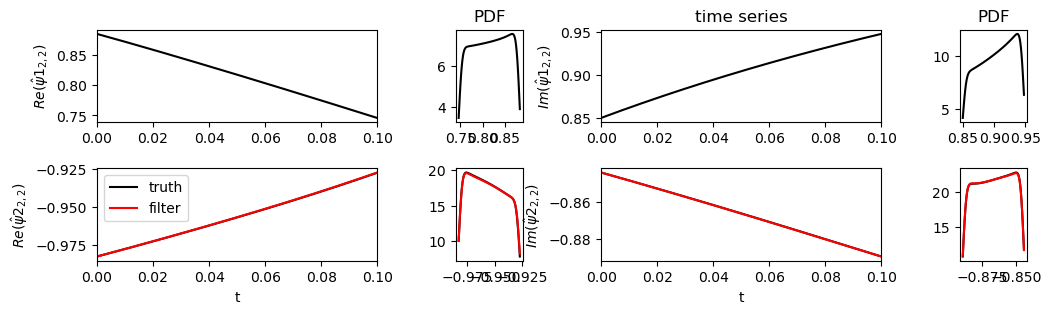

In [59]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
plt.savefig('./Lagrangian_DA/CGDA_K16_tr.png',dpi=100)
plt.show()

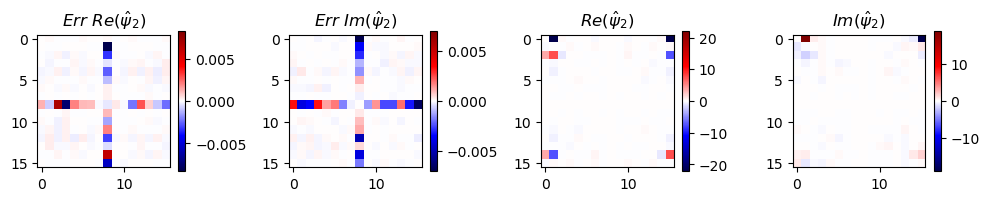

In [60]:
# plot error mode
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1] = (mu_t[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,3] = psi2_k_t[:, :, -1].imag

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/da_err_psi2_K16_tr.png', dpi=100)
plt.show()

## 2.2 Imperfect model (full QG vs CG model)

### 2.2.1 Full mode (K=16)

#### 2.2.1.1 $\beta=60$ (stable flow)

In [83]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-6_beta60_K16_dt1e-4.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 100000)


In [84]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # enforce conjugate symmetry
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0
#     psi1_hat[:, K//2, :] = 0
#     psi2_hat[:, K//2, :] = 0

    # Precompute constants
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    dX[:, K//2] = 0 # enforce conjugate symmetry

    # linear part for A0, a0, A1 and a1
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, imy, imx]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    nonlinear_sum_A1[:, K//2::K, :] = 0
    nonlinear_sum_A1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_a1[:, K//2::K, :] = 0
    nonlinear_sum_a1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_A0[:, :, K//2] = 0
    nonlinear_sum_a0[:, :, K//2] = 0
    nonlinear_sum_A0[:, K//2, :] = 0
    nonlinear_sum_a0[:, K//2, :] = 0
    A1[:, K//2::K, :] = 0
    A1[:, K//2*K:(K//2+1)*K, :] = 0
    a1[:, K//2::K, :] = 0
    a1[:, K//2*K:(K//2+1)*K, :] = 0
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

In [85]:
# DA
N = 100000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# initialized
sigma_1 = 1.
sigma_2 = 4. * np.ones(K**2)
InvBoB = 1 / sigma_1**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
N_chunk = 2000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t= get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_k_t[:,:,i-1:i-1+N_chunk], psi2_k_t[:,:,i-1:i-1+N_chunk], h_hat)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_16397/4245595930.py:87: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [86]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 100000)

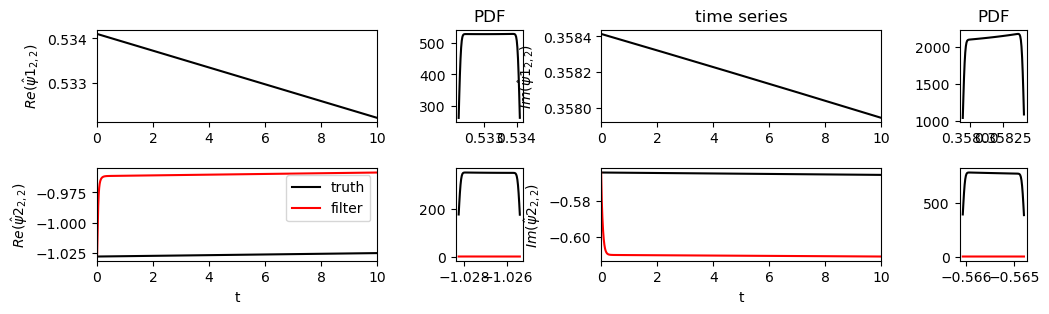

In [87]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/CGDA_K16.png',dpi=100)
plt.show()

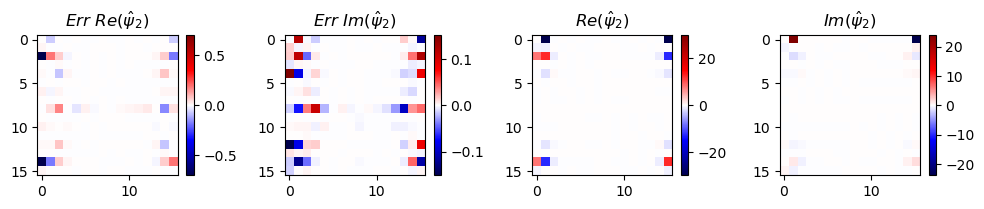

In [88]:
# plot error mode
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1] = (mu_t[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,3] = psi2_k_t[:, :, -1].imag

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
# plt.savefig('./Lagrangian_DA/da_err_psi2_K16.png', dpi=100)
plt.show()

In [92]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi2_pos = np.zeros_like(mu_t)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(mu_t[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-2:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

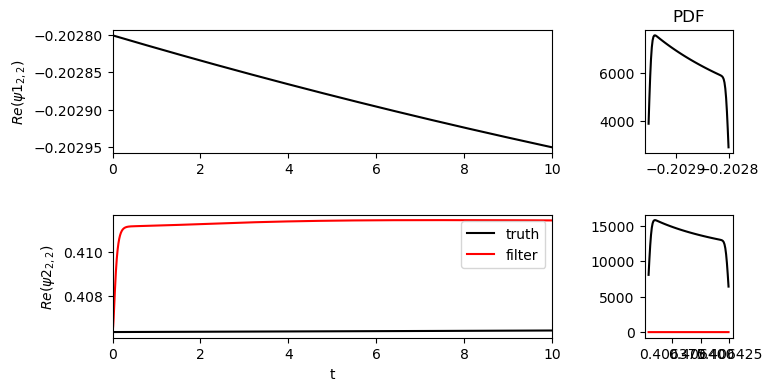

In [94]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/CGDA_K16_real.png',dpi=100)
plt.show()

#### 2.2.1.2 $\beta=22$ (less stable flow)

In [82]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-5_beta22_K16_dt1e-4.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
#     s_rate = file['s_rate'][()][0,0]
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 100000)


In [98]:
def get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    K = KX.shape[0]
    
    # psi_hat, hk should be of shape (N, K, K), if not, reshape them to make it legible
    if psi1_hat.shape[-2:] != KX.shape:
        psi1_hat = np.transpose(psi1_hat, axes=(2,0,1))
    if psi2_hat.shape[-2:] != KX.shape:
        psi2_hat = np.transpose(psi2_hat, axes=(2,0,1))
    if h_hat.shape[-2:] != KX.shape:
        h_hat = np.transpose(h_hat, axes=(2,0,1))

#     # enforce conjugate symmetry
#     psi1_hat[:, :, K//2] = 0
#     psi2_hat[:, :, K//2] = 0
#     psi1_hat[:, K//2, :] = 0
#     psi2_hat[:, K//2, :] = 0

    # Precompute constants
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    dX[:, K//2] = 0 # enforce conjugate symmetry

    # linear part for A0, a0, A1 and a1
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag.flatten(order='F'))[None,:,:], (psi1_hat.shape[0],1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K)}
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, imy, imx]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                inx, iny = k_index_map[n]
                psi1_n = psi1_hat[:, iny, inx]
                h_n = h_hat[iny, inx]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, iky, ikx] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, iky, ikx] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # enforce conjugate symmetry
    nonlinear_sum_A1[:, K//2::K, :] = 0
    nonlinear_sum_A1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_a1[:, K//2::K, :] = 0
    nonlinear_sum_a1[:, K//2*K:(K//2+1)*K, :] = 0
    nonlinear_sum_A0[:, :, K//2] = 0
    nonlinear_sum_a0[:, :, K//2] = 0
    nonlinear_sum_A0[:, K//2, :] = 0
    nonlinear_sum_a0[:, K//2, :] = 0
    A1[:, K//2::K, :] = 0
    A1[:, K//2*K:(K//2+1)*K, :] = 0
    a1[:, K//2::K, :] = 0
    a1[:, K//2*K:(K//2+1)*K, :] = 0
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck.flatten(order='F')[None,:,None], (psi1_hat.shape[0],1,K**2))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    # flatten
    A0 = A0.reshape((A0.shape[0], -1), order='F')
    a0 = a0.reshape((a0.shape[0], -1), order='F')
    
    return A0, a0, A1, a1

In [99]:
# DA
N = 100000
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(kx, ky)
K_squared = KX**2 + KY**2

# initialized
sigma_1 = 1.
sigma_2 = 4. * np.ones(K**2)
InvBoB = 1 / sigma_1**2

# initialized mean and variance
mu0 = psi2_k_t[:,:,0].flatten(order='F') # assume the initial condition is truth
K_ = mu0.shape[0] # flattened K*K
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# Lagrangian DA
N_chunk = 2000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t= get_coef_mat(KX, KY, K_squared, kd, beta, kappa, nu, U, psi1_k_t[:,:,i-1:i-1+N_chunk], psi2_k_t[:,:,i-1:i-1+N_chunk], h_hat)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    psi1_diff = psi1_k_t[:, :, i] - psi1_k_t[:, :, i - 1]
    psi1_diff = psi1_diff.flatten(order='F')

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_16397/4245595930.py:87: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [100]:
# reshape flattened variables to two modes matrices
mu_t = mu_t.reshape((K,K,-1), order='F')
mu_t.shape

(16, 16, 100000)

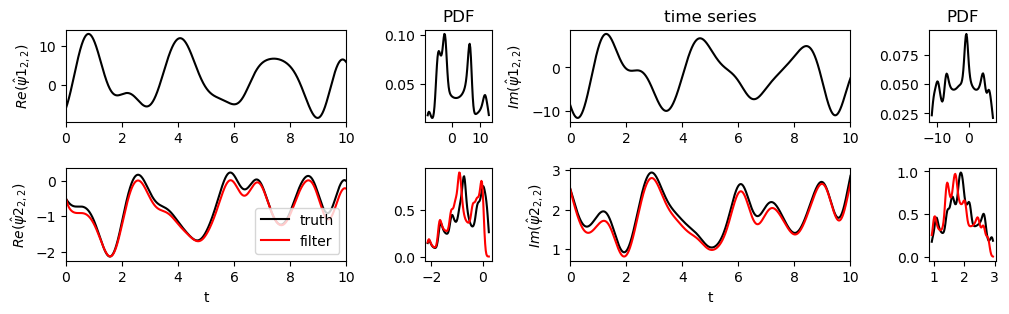

In [105]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # mode to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t[iky,ikx,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(ikx, iky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t[iky,ikx,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[iky,ikx,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(ikx, iky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t[iky, ikx, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[iky, ikx, :].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
plt.savefig('./Lagrangian_DA/CGDA_K16_fullQG_beta22.png',dpi=100)
plt.show()

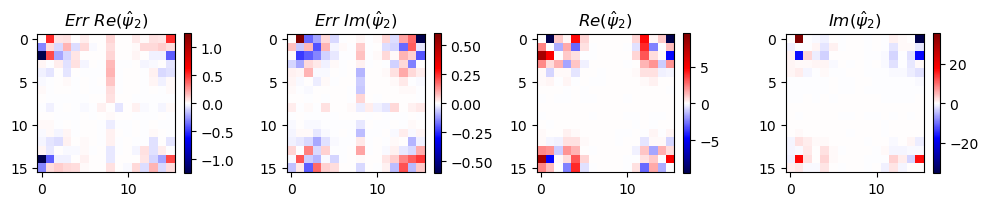

In [106]:
# plot error mode
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1] = (mu_t[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,3] = psi2_k_t[:, :, -1].imag

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/da_err_psi2_K16_fullQG_beta22.png', dpi=100)
plt.show()

In [103]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi2_pos = np.zeros_like(mu_t)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(mu_t[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-2:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

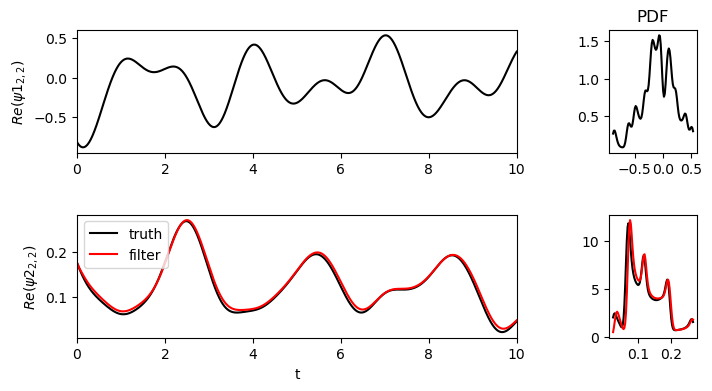

In [107]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

plt.savefig('./Lagrangian_DA/CGDA_K16_fullQG_beta22_real.png',dpi=100)
plt.show()

### 2.2.2 Mode truncation

#### 2.2.2.1  K=16

In [5]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-5_beta22_K16_dt1e-4.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'u1_t', 'utz', 'v1_t', 'vb']>
psi1_k_t.shape (16, 16, 100000)


##### 2.2.2.1.1 $\beta=22, \nu=10^{-12}$

###### $r_{cut}=10$

In [8]:
def truncate(kk, r, style='circle'):
    '''
    1. require the input kk has shape (K,) or (K,K,...)
    2. r is the radius to be preserved.
    3. style = 'circle' or 'square', default is 'circle'
    4. return flattened modes with 'F' order with shape (k_left,...)
    '''
    K = kk.shape[0]

    if kk.ndim == 1:
        index_to_remove = np.zeros(K, dtype=bool)
        index_to_remove[r+1:-r] = True
        new_shape = np.array(kk.shape)
        new_shape[:2] = min((2*r+1), K)
        kk_cut = kk[~index_to_remove].reshape(new_shape)
        
    elif kk.ndim > 1:
        if style == 'square':
            index_to_remove = np.zeros((K, K), dtype=bool)
            index_to_remove[r+1:-r, :] = True
            index_to_remove[:, r+1:-r] = True
            k_left = min((2*r+1), K)**2
            
        elif style == 'circle':
            index_to_remove = np.ones((K, K), dtype=bool)
            k_left = 0
            for ix in range(K):
                for iy in range(K):
                    r2_xy = min((ix**2 + iy**2), ((ix-K)**2 + iy**2), ((iy-K)**2 + ix**2), ((ix-K)**2 + (iy-K)**2))
                    if r2_xy <= r**2:
                        index_to_remove[ix,iy] = False  
                        k_left += 1
                                    
        # To retrieve elements in Fortran ('F') order:
        axes = np.arange(kk.ndim)
        axes[0], axes[1] = axes[1], axes[0]
        kk_T = np.transpose(kk, axes)
        kk_cut = kk_T[~index_to_remove.T]

        # Returned flattened truncatation modes with order 'F' 
        new_shape = np.array(kk.shape[1:])
        new_shape[0] = k_left
        kk_cut = kk_cut.reshape(new_shape, order='F')

    return kk_cut

In [9]:
def inv_truncate(kk_truncated, r, K, style='circle'):
    ''' Recovers the original array from a truncated version by filling zeros.
        Parameters:
        - kk_truncated: The truncated array of shape (k_left,...).
        - r: radius to be preserved.
        - style: 'circle' or square.
    '''
    if kk_truncated.ndim == 1:
        recovered = np.zeros(K, dtype=kk_truncated.dtype)
        recovered[:r+1] = kk_truncated[:r+1]
        recovered[-r:] = kk_truncated[-r:]

    elif kk_truncated.ndim > 1:
        k_left = kk_truncated.shape[0]
        new_shape = [K] + list(kk_truncated.shape)
        new_shape[1] = K
        recovered = np.zeros(new_shape, dtype=kk_truncated.dtype)
        if style == 'square':
            k_cut = int(np.sqrt(k_left))
            shape_cut = [k_cut, k_cut] + list(kk_truncated.shape[1:])
            kk_temp = np.reshape(kk_truncated, shape_cut, order='F')
            recovered[:r+1, :r+1] = kk_temp[:r+1, :r+1]
            recovered[-r:, :r+1] = kk_temp[-r:, :r+1]
            recovered[:r+1, -r:] = kk_temp[:r+1, -r:]
            recovered[-r:, -r:] = kk_temp[-r:, -r:]
            
        elif style == 'circle':
            kx = np.fft.fftfreq(K) * K
            ky = np.fft.fftfreq(K) * K
            KX, KY = np.meshgrid(kx, ky)
            k_index_map = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K) if (KX[iy, ix]**2 + KY[iy, ix]**2) <=r**2}
            for ik_, (k, ik) in enumerate(k_index_map.items()):
                ikx, iky = ik
                recovered[iky, ikx] = kk_truncated[ik_]
            
    return recovered

In [10]:
def get_coef_mat(K, KX, KY, k_index_map, r, kd, beta, kappa, nu, U, psi1_hat, psi2_hat, h_hat):
    '''
    1. The mode truncation should be done outside this function. 
    2. K is the original number of modes in each x and y direction. 
    3. psi_hat, hk should be of shape (N,k_left) for proper broadcasting.
    '''
    N, k_left = psi1_hat.shape
    
    # Precompute constants
    K_squared = KX**2 + KY**2
    K_squared_kd2 = K_squared + kd**2 / 2
    K_squared2 = K_squared**2
    K_squared4 = K_squared**4
    invCk = K_squared * (K_squared + kd**2)
    dX = 1j * KX
    list_dic_k_map = list(k_index_map.keys())

    # linear part for A0, a0, A1 and a1
    linear_A0 = dX * ((K_squared_kd2 * beta - K_squared2 * U) * psi1_hat - kd**2/2 * U * h_hat) - nu * K_squared4 * (invCk * psi1_hat - kd**2/2 * h_hat)
    linear_a0 = dX * ((kd**2/2 * beta - kd**2 * K_squared * U) * psi1_hat - K_squared_kd2 * U * h_hat) + nu * K_squared4 * K_squared_kd2 * h_hat
    linear_A1_diag = dX * (kd**2/2 * beta + kd**2 * K_squared * U) - (kd**2/2 * kappa * K_squared)
    linear_a1_diag = dX * (K_squared_kd2 * beta + K_squared2 * U) - K_squared_kd2 * kappa * K_squared - nu * K_squared4 * invCk
    linear_A1 = np.tile(np.diag(linear_A1_diag)[None,:,:], (N,1,1)) 
    linear_a1 = np.tile(np.diag(linear_a1_diag)[None,:,:], (N,1,1)) 
    
    # nonlinear summation part for A0, a0, A1 and a1
    nonlinear_sum_A0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_a0 = np.zeros_like(psi1_hat, dtype=complex)
    nonlinear_sum_A1 = np.zeros_like(linear_A1, dtype=complex)
    nonlinear_sum_a1 = np.zeros_like(linear_a1, dtype=complex)
    
    for ik_, (k, ik) in enumerate(k_index_map.items()):
        kx, ky = k
        ikx, iky = ik
        k_sq = kx**2 + ky**2
        for im_, (m, im) in enumerate(k_index_map.items()):
            mx, my = m
            imx, imy = im
            m_sq = mx**2 + my**2
            psi1_m = psi1_hat[:, im_]
            n = (kx-mx, ky-my)
            if n in k_index_map:
                in_ = list_dic_k_map.index(n)
                psi1_n = psi1_hat[:, in_]
                h_n = h_hat[in_]
                det_mn = np.linalg.det(np.array([m, n]))
                nonlinear_sum_A0[:, ik_] -= det_mn * ((k_sq + kd**2/2) * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_a0[:, ik_] -= det_mn * (kd**2/2 * (m_sq + kd**2/2) * psi1_n*psi1_m)
                nonlinear_sum_A1[:, ik_, im_] += det_mn * kd**2/2 * (k_sq * psi1_n - h_n)
                nonlinear_sum_a1[:, ik_, im_] -= det_mn * (k_sq * kd**2/2 * psi1_n + (k_sq + kd**2/2) * h_n) 
        
    nonlinear_sum_A0 = nonlinear_sum_A0 / K**2
    nonlinear_sum_a0 = nonlinear_sum_a0 / K**2
    nonlinear_sum_A1 = nonlinear_sum_A1 / K**2
    nonlinear_sum_a1 = nonlinear_sum_a1 / K**2
    
    # aggregate 
    A0 = linear_A0 + nonlinear_sum_A0
    a0 = linear_a0 + nonlinear_sum_a0
    A1 = linear_A1 + nonlinear_sum_A1
    a1 = linear_a1 + nonlinear_sum_a1
    
    # normalization 
    Ck = 1 / invCk
    Ck[K_squared == 0] = 0  # avoid division by zero at k = 0, constant mode
    Ck_ = np.tile(Ck[None,:,None], (N,1,k_left))
    A0 = Ck * A0
    a0 = Ck * a0
    A1 = Ck_ * A1
    a1 = Ck_ * a1
    
    return A0, a0, A1, a1

In [88]:
# DA
N = 100000
Kx = np.fft.fftfreq(K) * K
Ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(Kx, Ky)
K_squared = KX**2 + KY**2

# enforce conjugate symmetry
psi1_k_t[:,K//2,:] = 0
psi2_k_t[:,K//2,:] = 0
psi1_k_t[K//2,:,:] = 0
psi2_k_t[K//2,:,:] = 0

# truncate
r = 10 # truncatation radius
KX_cut = truncate(KX, r, style='circle')
KY_cut = truncate(KY, r, style='circle')
k_index_map_cut = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K) if (KX[iy, ix]**2 + KY[iy, ix]**2) <=r**2}
psi1_k_t_cut = truncate(psi1_k_t, r, style='circle')
psi2_k_t_cut = truncate(psi2_k_t, r, style='circle')
h_k_cut = truncate(h_hat, r, style='circle')

# psi_hat, hk should be of shape shape (N,k_left)
psi1_k_t_cut_T = np.transpose(psi1_k_t_cut, axes=(1,0))
psi2_k_t_cut_T = np.transpose(psi2_k_t_cut, axes=(1,0))

# initialized mean and variance
mu0 = psi2_k_t_cut[:, 0] # assume the initial condition is truth
K_ = mu0.shape[0] # number of flattened K modes
R0 = np.zeros((K_, K_), dtype='complex')
mu_t = np.zeros((K_, N), dtype='complex')  # posterior mean
mu_t[:, 0] = mu0
R_t = np.zeros((K_, N), dtype='complex')  # posterior covariance
R_t[:, 0] = np.diag(R0)  # only save the diagonal elements
sigma_1 = 1.
sigma_2 = 4. * np.ones(K_)
InvBoB = 1 / sigma_1**2

# Lagrangian DA
N_chunk = 1000 

for i in range(1, N):
    i_chunk = (i-1) % N_chunk
    if i_chunk == 0:
        A0_t, a0_t, A1_t, a1_t= get_coef_mat(K, KX_cut, KY_cut, k_index_map_cut, r, kd, beta, kappa, nu, U, psi1_k_t_cut_T[i-1:i-1+N_chunk,:], psi2_k_t_cut_T[i-1:i-1+N_chunk,:], h_k_cut)
    
    A0 = A0_t[i_chunk, :]
    a0 = a0_t[i_chunk, :]
    A1 = A1_t[i_chunk, :, :]
    a1 = a1_t[i_chunk, :, :]

    psi1_diff = psi1_k_t_cut_T[i, :] - psi1_k_t_cut_T[i-1, :]

    # Update the posterior mean and posterior covariance
    mu = mu0 + (a0 + a1 @ mu0) * dt + (R0 @ A1.conj().T) * InvBoB @ (psi1_diff - (A0 + A1 @ mu0) * dt)
    R = R0 + (a1 @ R0 + R0 @ a1.conj().T + np.diag(sigma_2**2) - (R0 @ A1.conj().T) * InvBoB @ A1 @ R0.conj().T) * dt
    mu_t[:, i] = mu
    R_t[:, i] = np.diag(R)
    mu0 = mu
    R0 = R

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_68848/2143567608.py:64: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


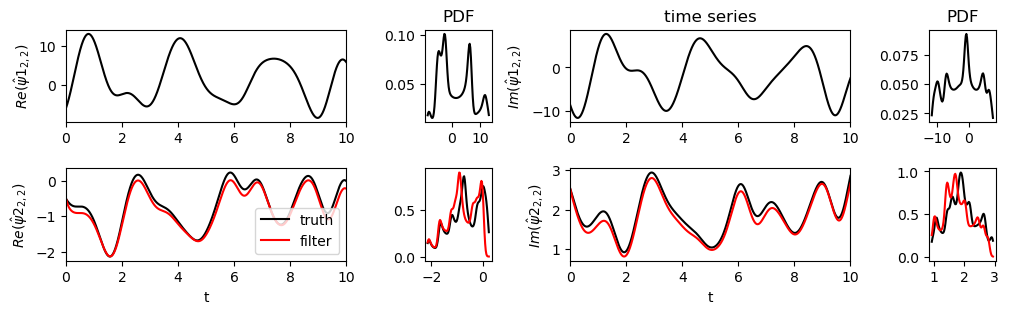

In [96]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
kx = 2; ky = 2 # mode to plot
ik_ = list(k_index_map_cut.keys()).index((kx, ky))
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t_cut[ik_,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))

ax2.plot(xaxis, psi2_k_t_cut[ik_,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[ik_,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t_cut[ik_, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t_cut[ik_, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[ik_, :N].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t_cut[ik_,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t_cut[ik_,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[ik_,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t_cut[ik_, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t_cut[ik_, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[ik_, :N].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/CGDA_K16_fullQG_beta22.png',dpi=100)
plt.show()

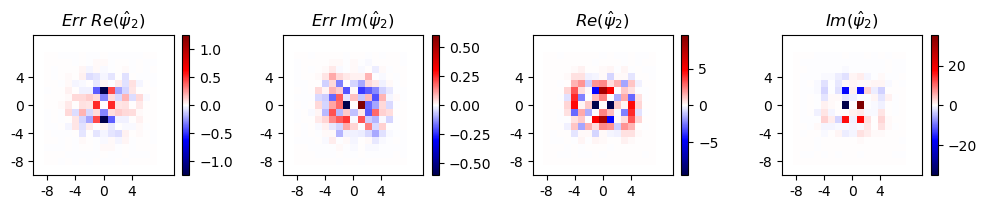

In [93]:
# plot error mode
mu_t_KK = inv_truncate(mu_t, r, K, style='circle')
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t_KK[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1] = (mu_t_KK[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,3] = psi2_k_t[:, :, -1].imag

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    n_tick = 4
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_xlim(K//2-r, K//2+r) 
    axs[j].set_ylim(K//2-r, K//2+r)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
# plt.savefig('./Lagrangian_DA/da_err_psi2_K16_fullQG_beta22.png', dpi=100)
plt.show()

In [94]:
# ifft to real space
psi1_t = np.zeros_like(psi1_k_t)
psi2_t = np.zeros_like(psi2_k_t)
psi2_pos = np.zeros_like(mu_t_KK)
for i in range(N):
    psi1_t[:,:,i] = np.fft.ifft2(psi1_k_t[:, :, i])
    psi2_t[:,:,i] = np.fft.ifft2(psi2_k_t[:, :, i])
    psi2_pos[:,:,i] = np.fft.ifft2(mu_t_KK[:, :, i])

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-2:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

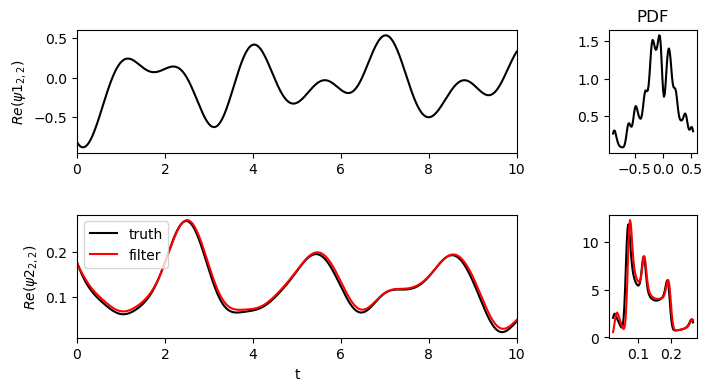

In [95]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/CGDA_K16_fullQG_beta22_real.png',dpi=100)
plt.show()

###### $r_{cut}=5$

In [12]:
# Lagrangian DA
N = psi1_k_t.shape[-1]
N_chunk = 2000
r_cut = 5
style = 'circle'
sigma_1 = 1.
sigma_2 = 4.
lsm_da = Lagrangian_DA_CG(N, N_chunk, K, dt, psi1_k_t, psi2_k_t, sigma_1, sigma_2, kd, beta, kappa, nu, U, h_hat, r_cut, style)
mu_t, R_t = lsm_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/daCG_pos_K16_beta22_tr.npz', **da_pos)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:97: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [15]:
# truth truncation
Kx = np.fft.fftfreq(K) * K
Ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(Kx, Ky)
KX_cut = truncate(KX, r_cut, style)
KY_cut = truncate(KY, r_cut, style)
k_index_map_cut = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K) if (KX[iy, ix]**2 + KY[iy, ix]**2) <=r_cut**2}

psi1_k_t_cut = truncate(psi1_k_t, r_cut, style)
psi2_k_t_cut = truncate(psi2_k_t, r_cut, style)

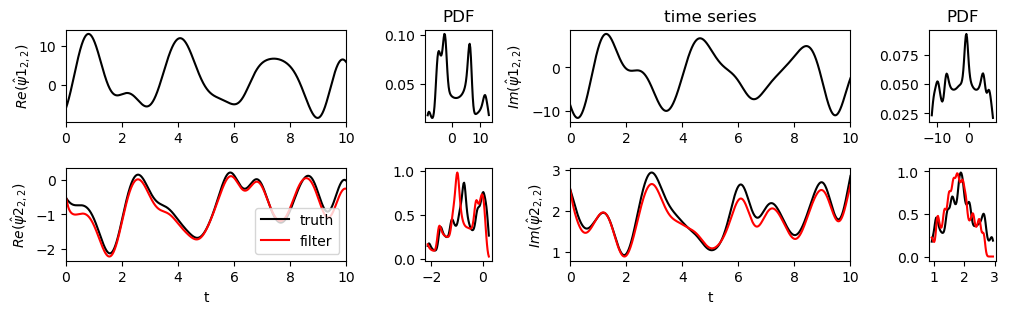

In [16]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
kx = 2; ky = 2 # mode to plot
ik_ = list(k_index_map_cut.keys()).index((kx, ky))
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t_cut[ik_,sel0:sel1:interv].real, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))

ax2.plot(xaxis, psi2_k_t_cut[ik_,sel0:sel1:interv].real, 'k', label='truth')
ax2.plot(xaxis, mu_t[ik_,sel0:sel1:interv].real, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_k_t_cut[ik_, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_k_t_cut[ik_, :N].real
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = mu_t[ik_, :N].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

ax11.plot(xaxis, psi1_k_t_cut[ik_,sel0:sel1:interv].imag, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t_cut[ik_,sel0:sel1:interv].imag, 'k', label='truth')
ax22.plot(xaxis, mu_t[ik_,sel0:sel1:interv].imag, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t_cut[ik_, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
ax33.set_title('PDF')

samples = psi2_k_t_cut[ik_, :N].imag
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
samples = mu_t[ik_, :N].imag
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
# plt.savefig('./Lagrangian_DA/CGDA_K16_fullQG_beta22_r5.png',dpi=100)
plt.show()

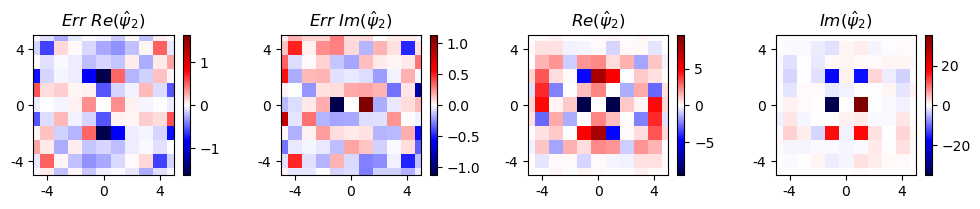

In [19]:
# plot error mode
mu_t_KK = inv_truncate(mu_t, r_cut, K, style)
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t_KK[:, :, -1] - psi2_k_t[:, :, -1]).real
dataplot[:,:,1] = (mu_t_KK[:, :, -1] - psi2_k_t[:, :, -1]).imag
dataplot[:,:,2] = psi2_k_t[:, :, -1].real
dataplot[:,:,3] = psi2_k_t[:, :, -1].imag

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    n_tick = 4
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_xticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_yticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_xlim(K//2-r_cut, K//2+r_cut) 
    axs[j].set_ylim(K//2-r_cut, K//2+r_cut)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
# plt.savefig('./Lagrangian_DA/da_err_psi2_K16_fullQG_beta22_r5.png', dpi=100)
plt.show()

In [20]:
# ifft to real space
psi1_t = np.fft.ifft2(psi1_k_t, axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t, axes=(0,1))
psi2_pos = np.fft.ifft2(mu_t_KK, axes=(0,1))

# check imaginary part
# max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))))
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

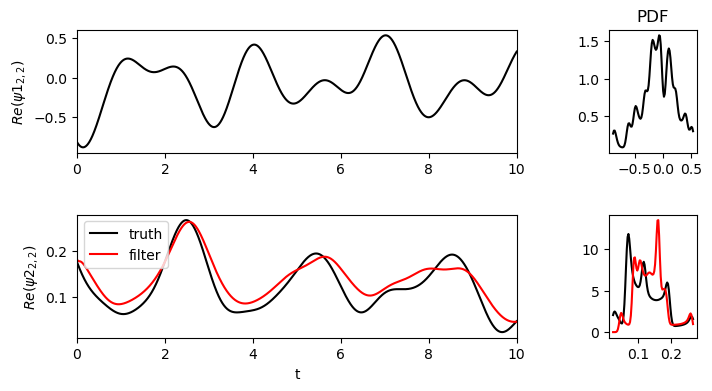

In [21]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1:interv], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1:interv], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1:interv], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()
# ax2.set_xlim(0,0.01)
# ax2.set_ylim(-2.58,-2.56)

# plot pdf
samples = psi1_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, :N]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, :].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')

# plt.savefig('./Lagrangian_DA/CGDA_K16_fullQG_beta22_r5_real.png',dpi=100)
plt.show()

#### 2.2.2.2 K=128

##### 2.2.2.2.1 $\beta=111, \nu=10^{-12}$

###### $r_{cut}=12$

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-12_beta111_K128_dt5e-4_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
#     psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
# psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>
psi1_k_t.shape (128, 128, 20000)


In [3]:
# truncate parameter
r_cut = 12
style = 'circle'

In [4]:
# Lagrangian DA
N = psi1_k_t_fine.shape[-1]
N_chunk = 800
sigma_1 = 1.
sigma_2 = 4.
cg_da = Lagrangian_DA_CG(N, N_chunk, K, dt, psi1_k_t_fine, psi2_k_t, sigma_1, sigma_2, kd, beta, kappa, nu, U, h_hat, r_cut, style)
mu_t, R_t = cg_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/CGDA_pos_K128_beta111_tr.npz', **da_pos)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:97: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [4]:
# # load DA data
da_pos = np.load('../data/CGDA_pos_K128_beta111_tr.npz')
mu_t = da_pos['mu_t']
R_t = da_pos['R_t']

In [5]:
# truth truncation
Kx = np.fft.fftfreq(K) * K
Ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(Kx, Ky)
KX_cut = truncate(KX, r_cut, style)
KY_cut = truncate(KY, r_cut, style)
k_index_map_cut = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K) if (KX[iy, ix]**2 + KY[iy, ix]**2) <=r_cut**2}

psi1_k_t_cut = truncate(psi1_k_t, r_cut, style)
psi2_k_t_cut = truncate(psi2_k_t, r_cut, style)

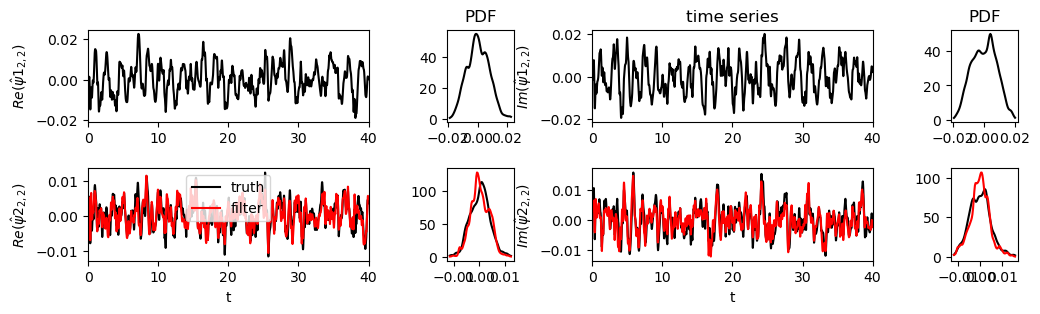

In [6]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
kx = 2; ky = 2 # mode to plot
ik_ = list(k_index_map_cut.keys()).index((kx, ky))
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].real / K**2, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))

ax2.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].real / K**2, 'k', label='truth')
ax2.plot(xaxis, mu_t[ik_,sel0:sel1:interv].real / K**2, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].real / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
ax4.set_yscale('log', base=10) 
ax4.set_ylim(1e-2, np.max(p))

ax11.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k', label='truth')
ax22.plot(xaxis, mu_t[ik_,sel0:sel1:interv].imag / K**2, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax33.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax33.set_yscale('log', base=10) 
ax33.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax44.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].imag / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
ax44.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/CGDA_K128_fullQG_beta111_r12.png',dpi=100)
plt.show()

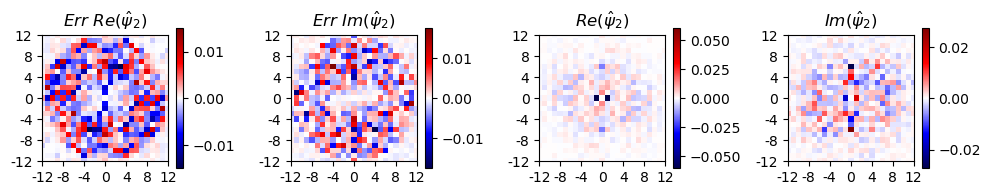

In [7]:
# plot error mode
mu_t_KK = inv_truncate(mu_t, r_cut, K, style)
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,1] = (mu_t_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,2] = psi2_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,3] = psi2_k_t[:, :, N//s_rate-1].imag / K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    n_tick = K//8*2
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_xticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_yticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_xlim(K//2-r_cut, K//2+r_cut) 
    axs[j].set_ylim(K//2-r_cut, K//2+r_cut)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/CGDA_err_psi2_K128_fullQG_beta111_r12.png', dpi=100)
plt.show()

In [6]:
# ifft to real space
mu_t_KK = inv_truncate(mu_t, r_cut, K, style)
interv = 10
psi1_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))
psi2_pos = np.fft.ifft2(mu_t_KK[:, :, ::s_rate*interv], axes=(0,1))

# check imaginary part
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

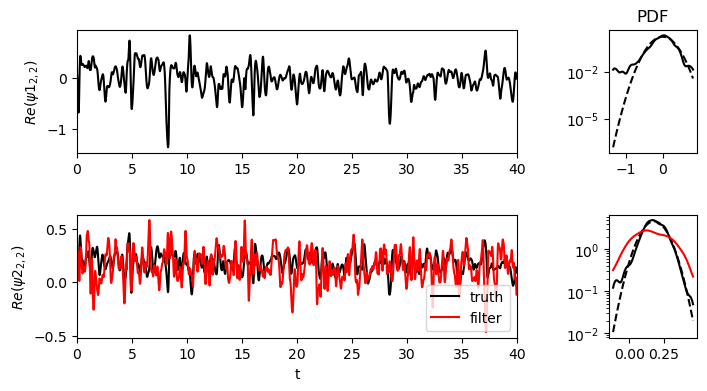

In [11]:
# Plot
sel0 = 0//(interv*s_rate); sel1 = N//(interv*s_rate) # plot time range
ikx = 2; iky = 2 # x,y to plot
# interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt, interv*s_rate*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1], 'k')
ax1.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax2.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi2_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
ax4.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/CGDA_K128_fullQG_beta111_r12_real.png',dpi=100)
plt.show()

In [10]:
# RMSE
# rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
# rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
# print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(lower layer): 0.14489460873833632


##### 2.2.2.2.2 $\beta=22, \nu=10^{-12}$

###### $r_{cut}=12$

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-12_beta22_K128_dt5e-4_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>
psi1_k_t.shape (128, 128, 20000)


In [3]:
# truncate parameter
r_cut = 12
style = 'circle'

In [4]:
# Lagrangian DA
N = psi1_k_t_fine.shape[-1]
N_chunk = 800
sigma_1 = 1.
sigma_2 = 4.
cg_da = Lagrangian_DA_CG(N, N_chunk, K, dt, psi1_k_t_fine, psi2_k_t, sigma_1, sigma_2, kd, beta, kappa, nu, U, h_hat, r_cut, style)
mu_t, R_t = cg_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/CGDA_pos_K128_beta22_tr.npz', **da_pos)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:97: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [4]:
# # load DA data
# da_pos = np.load('../data/CGDA_pos_K128_beta22_tr.npz')
# mu_t = da_pos['mu_t']
# R_t = da_pos['R_t']

In [5]:
# truth truncation
Kx = np.fft.fftfreq(K) * K
Ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(Kx, Ky)
KX_cut = truncate(KX, r_cut, style)
KY_cut = truncate(KY, r_cut, style)
k_index_map_cut = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K) if (KX[iy, ix]**2 + KY[iy, ix]**2) <=r_cut**2}

psi1_k_t_cut = truncate(psi1_k_t, r_cut, style)
psi2_k_t_cut = truncate(psi2_k_t, r_cut, style)

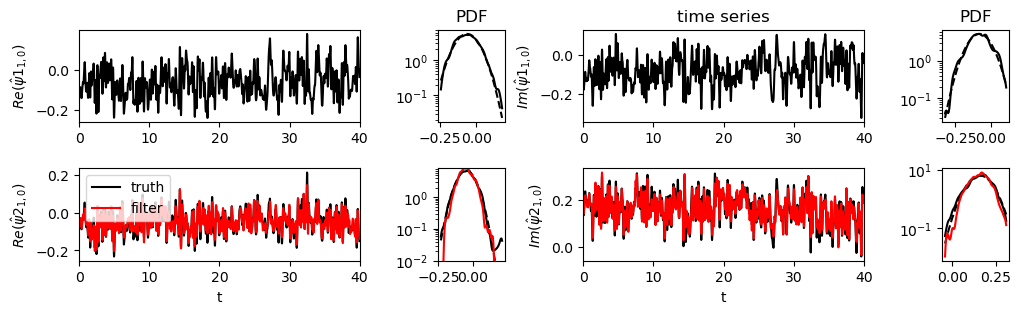

In [28]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
kx = 1; ky = 0 # mode to plot
ik_ = list(k_index_map_cut.keys()).index((kx, ky))
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].real / K**2, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))

ax2.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].real / K**2, 'k', label='truth')
ax2.plot(xaxis, mu_t[ik_,sel0:sel1:interv].real / K**2, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].real / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
ax4.set_yscale('log', base=10) 
ax4.set_ylim(1e-2, np.max(p))

ax11.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k', label='truth')
ax22.plot(xaxis, mu_t[ik_,sel0:sel1:interv].imag / K**2, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax33.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax33.set_yscale('log', base=10) 
ax33.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax44.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].imag / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
ax44.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/CGDA_K128_fullQG_beta22_r12.png',dpi=100)
plt.show()

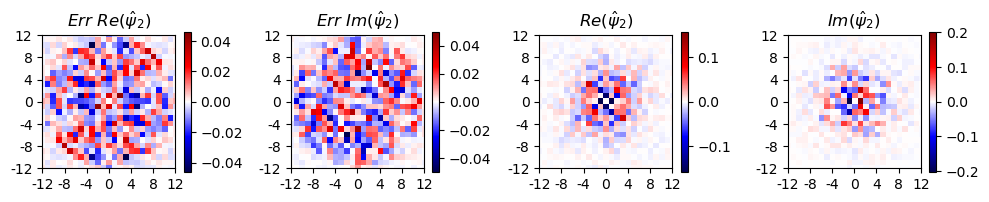

In [7]:
# plot error mode
mu_t_KK = inv_truncate(mu_t, r_cut, K, style)
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,1] = (mu_t_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,2] = psi2_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,3] = psi2_k_t[:, :, N//s_rate-1].imag / K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    n_tick = K//8*2
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_xticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_yticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_xlim(K//2-r_cut, K//2+r_cut) 
    axs[j].set_ylim(K//2-r_cut, K//2+r_cut)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/CGDA_err_psi2_K128_fullQG_beta22_r12.png', dpi=100)
plt.show()

In [8]:
# ifft to real space
mu_t_KK = inv_truncate(mu_t, r_cut, K, style)
interv = 10
psi1_t = np.fft.ifft2(psi1_k_t[:, :, ::interv], axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t[:, :, ::interv], axes=(0,1))
psi2_pos = np.fft.ifft2(mu_t_KK[:, :, ::s_rate*interv], axes=(0,1))

# check imaginary part
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

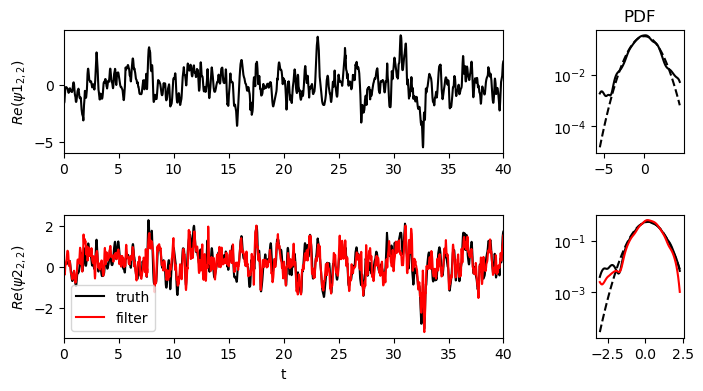

In [9]:
# Plot
sel0 = 0//(interv*s_rate); sel1 = N//(interv*s_rate) # plot time range
ikx = 2; iky = 2 # x,y to plot
# interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt, interv*s_rate*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0:sel1], 'k')
ax1.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0:sel1], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0:sel1], 'r', label='filter')
ax2.set_xlim(sel0*(interv*s_rate)*dt, sel1*(interv*s_rate)*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, sel0:sel1]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = psi2_pos[iky, ikx, sel0:sel1].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
ax4.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/CGDA_K128_fullQG_beta22_r12_real.png',dpi=100)
plt.show()

In [10]:
# RMSE
# rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
# rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
# print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(lower layer): 0.4532501531931087


##### 2.2.2.2.3 $\beta=3, \nu=10^{-12}$

###### $r_{cut}=12$

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu1e-12_beta3_K128_dt5e-4_subs.mat'
with h5py.File(data_path, 'r') as file:
    print("Keys: %s" % file.keys())
    psi1_k_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_k_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi1_k_t_fine = np.transpose(file['psi_1_t_fine'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    s_rate = int(file['s_rate'][()][0,0])
    params_dataset = file['params']
    nu = params_dataset['nu'][()] [0,0]
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    kappa = params_dataset['r'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = np.transpose(file['topo'][()], axes=(1,0))
# dt = dt * s_rate
print('psi1_k_t.shape',psi1_k_t.shape)
psi1_k_t = psi1_k_t['real'] + 1j * psi1_k_t['imag']
psi2_k_t = psi2_k_t['real'] + 1j * psi2_k_t['imag']
psi1_k_t_fine = psi1_k_t_fine['real'] + 1j * psi1_k_t_fine['imag']
h_hat = np.fft.fft2(topo)

Keys: <KeysViewHDF5 ['#refs#', 'T', 'ape', 'countDiag', 'cut', 'dt', 'ene', 'etp', 'ii', 'ke', 'params', 'psi_1_t', 'psi_1_t_fine', 'psi_2_t', 'qp', 's_rate', 'tol', 'topo', 'utz', 'vb']>
psi1_k_t.shape (128, 128, 10000)


In [3]:
# truncate parameter
r_cut = 12
style = 'circle'

In [4]:
# Lagrangian DA
N = psi1_k_t_fine.shape[-1]
N_chunk = 500
sigma_1 = 1.
sigma_2 = 4.
cg_da = Lagrangian_DA_CG(N, N_chunk, K, dt, psi1_k_t_fine, psi2_k_t, sigma_1, sigma_2, kd, beta, kappa, nu, U, h_hat, r_cut, style)
mu_t, R_t = cg_da.forward()

# save data
da_pos = {
    'mu_t': mu_t,
    'R_t': R_t,
    'r_cut':r_cut,
    'style':style,
    'dt': dt
}
np.savez('../data/CGDA_pos_K128_beta3_tr.npz', **da_pos)

/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/Lagrangian_DA.py:97: RuntimeWarning: divide by zero encountered in divide
  Ck = 1 / invCk


In [4]:
# load DA data
da_pos = np.load('../data/CGDA_pos_K128_beta3_tr.npz')
mu_t = da_pos['mu_t']
R_t = da_pos['R_t']

In [7]:
# truth truncation
Kx = np.fft.fftfreq(K) * K
Ky = np.fft.fftfreq(K) * K
KX, KY = np.meshgrid(Kx, Ky)
KX_cut = truncate(KX, r_cut, style)
KY_cut = truncate(KY, r_cut, style)
k_index_map_cut = {(KX[iy, ix], KY[iy, ix]): (ix, iy) for ix in range(K) for iy in range(K) if (KX[iy, ix]**2 + KY[iy, ix]**2) <=r_cut**2}

psi1_k_t_cut = truncate(psi1_k_t, r_cut, style)
psi2_k_t_cut = truncate(psi2_k_t, r_cut, style)

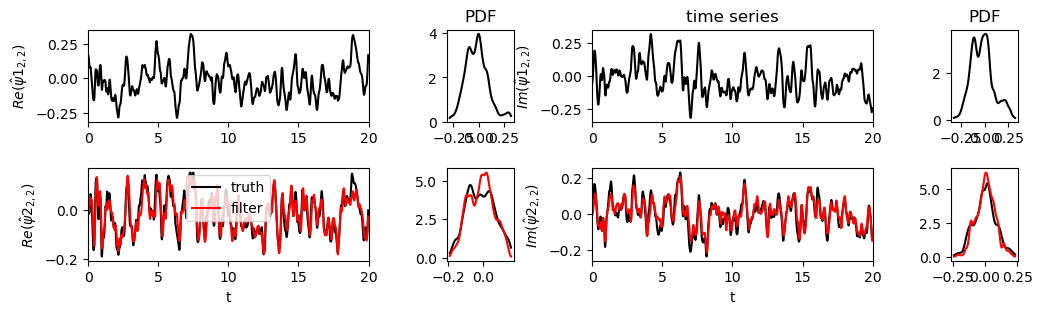

In [12]:
# Plot the time series
sel0 = 0; sel1 = N # plot time range
kx = 2; ky = 2 # mode to plot
ik_ = list(k_index_map_cut.keys()).index((kx, ky))
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,3))
widths = [5, 1.2, 5, 1.2]
heights = [1, 1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.45, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])
ax11 = fig.add_subplot(spec[0, 2])
ax22 = fig.add_subplot(spec[1, 2])
ax33 = fig.add_subplot(spec[0, 3])
ax44 = fig.add_subplot(spec[1, 3])

# plot time series
ax1.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].real / K**2, 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))

ax2.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].real / K**2, 'k', label='truth')
ax2.plot(xaxis, mu_t[ik_,sel0:sel1:interv].real / K**2, 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].real / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].real / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
ax4.set_yscale('log', base=10) 
ax4.set_ylim(1e-2, np.max(p))

ax11.plot(xaxis, psi1_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k')
ax11.set_xlim(sel0*dt, sel1*dt)
ax11.set_ylabel('$Im(\hat{{\psi}}1_{{{:d},{:d}}})$'.format(kx, ky))
ax11.set_title('time series')

ax22.plot(xaxis, psi2_k_t_cut[ik_,sel0//s_rate:sel1//s_rate:interv//s_rate].imag / K**2, 'k', label='truth')
ax22.plot(xaxis, mu_t[ik_,sel0:sel1:interv].imag / K**2, 'r', label='filter')
ax22.set_xlim(sel0*dt, sel1*dt)
ax22.set_ylabel(r'$Im(\hat{{\psi}}2_{{{:d},{:d}}})$'.format(kx, ky))
ax22.set_xlabel('t')

# plot pdf
samples = psi1_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax33.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax33.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax33.set_yscale('log', base=10) 
ax33.set_title('PDF')

samples = psi2_k_t_cut[ik_, sel0//s_rate:sel1//s_rate].imag / K**2
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'k', label='truth')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax44.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
samples = mu_t[ik_, sel0:sel1].imag / K**2
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax44.plot(xticks, p, 'r', label='filter')
ax44.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/CGDA_K128_fullQG_beta3_r12.png',dpi=100)
plt.show()

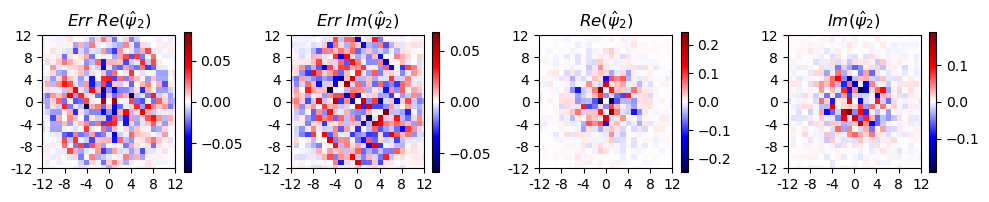

In [35]:
# plot error mode
mu_t_KK = inv_truncate(mu_t, r_cut, K, style)
fig, axs = plt.subplots(1, 4, figsize=(10,2))  # Creates a 2x2 grid of subplots

dataplot = np.zeros((K,K,4))
dataplot[:,:,0] = (mu_t_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).real / K**2
dataplot[:,:,1] = (mu_t_KK[:, :, N-1] - psi2_k_t[:, :, N//s_rate-1]).imag / K**2
dataplot[:,:,2] = psi2_k_t[:, :, N//s_rate-1].real / K**2
dataplot[:,:,3] = psi2_k_t[:, :, N//s_rate-1].imag / K**2

dataplot = np.roll(dataplot, shift=K//2, axis=0)
dataplot = np.roll(dataplot, shift=K//2, axis=1)
Kx_shift = np.roll(Kx, shift=K//2, axis=0) 

# Plotting the imaginary part of the last index in the third dimension
for j in range(4):
    n_tick = K//8*2
    maxabs = np.max(abs(dataplot[:, :, j]))
    im = axs[j].imshow(dataplot[:, :, j], cmap='seismic', vmin=-maxabs, vmax=maxabs)
    axs[j].set_xticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_xticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_yticks(np.linspace(0, K, num=n_tick, endpoint=False))  # Example for 5 ticks
    axs[j].set_yticklabels(Kx[::K//n_tick].astype(int))
    axs[j].set_xticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_yticklabels(Kx_shift[::K//n_tick].astype(int))
    axs[j].set_xlim(K//2-r_cut, K//2+r_cut) 
    axs[j].set_ylim(K//2-r_cut, K//2+r_cut)
    fig.colorbar(im, ax=axs[j])

axs[0].set_title(f'$Err\ Re(\hat{{\psi}}_2)$')
axs[1].set_title(f'$Err\ Im(\hat{{\psi}}_2)$')
axs[2].set_title(f'$Re(\hat{{\psi}}_2)$')
axs[3].set_title(f'$Im(\hat{{\psi}}_2)$')

plt.tight_layout()
plt.savefig('./Lagrangian_DA/CGDA_err_psi2_K128_fullQG_beta3_r12.png', dpi=100)
plt.show()

In [10]:
# ifft to real space
psi1_t = np.fft.ifft2(psi1_k_t, axes=(0,1))
psi2_t = np.fft.ifft2(psi2_k_t, axes=(0,1))
psi2_pos = np.fft.ifft2(mu_t_KK[:, :, ::s_rate], axes=(0,1))

# check imaginary part
max_imag_abs = max(np.max(np.abs(np.imag(psi1_t))), np.max(np.abs(np.imag(psi2_t))), np.max(np.abs(np.imag(psi2_pos))))
if max_imag_abs > 1e-6:
    raise Exception("get significant imaginary parts, check ifft2")
else:
    psi1_t = np.real(psi1_t)
    psi2_t = np.real(psi2_t)
    psi2_pos = np.real(psi2_pos)

# shift domain from [0,2pi) to [-pi,pi)
psi1_t = np.roll(psi1_t, shift=K//2, axis=0) 
psi1_t = np.roll(psi1_t, shift=K//2, axis=1) 
psi2_t = np.roll(psi2_t, shift=K//2, axis=0)
psi2_t = np.roll(psi2_t, shift=K//2, axis=1)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=0)
psi2_pos = np.roll(psi2_pos, shift=K//2, axis=1)

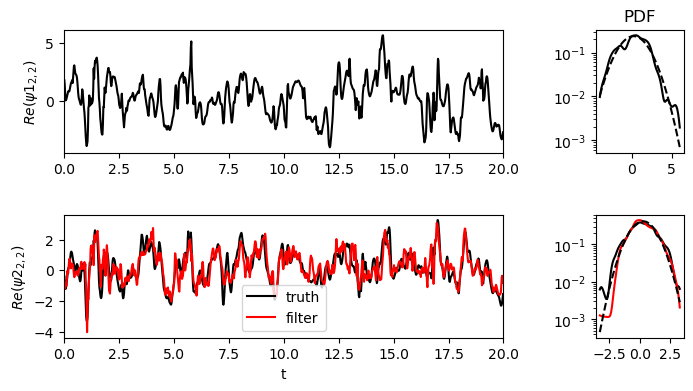

In [14]:
# Plot
sel0 = 0; sel1 = N # plot time range
ikx = 2; iky = 2 # x,y to plot
interv = 10*s_rate # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(8,4))
widths = [5, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.35, hspace=0.5)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1])

# plot time series
ax1.plot(xaxis, psi1_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate], 'k')
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_ylabel('$Re(\psi1_{{{:d},{:d}}})$'.format(ikx, iky))

ax2.plot(xaxis, psi2_t[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate], 'k', label='truth')
ax2.plot(xaxis, psi2_pos[iky,ikx,sel0//s_rate:sel1//s_rate:interv//s_rate], 'r', label='filter')
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_ylabel(r'$Re(\psi2_{{{:d},{:d}}})$'.format(ikx, iky))
ax2.set_xlabel('t')
ax2.legend()

# plot pdf
samples = psi1_t[iky, ikx, sel0//s_rate:sel1//s_rate]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax3.plot(xticks, p, 'k')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax3.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax3.set_yscale('log', base=10) 
ax3.set_title('PDF')

samples = psi2_t[iky, ikx, sel0//s_rate:sel1//s_rate]
kde = gaussian_kde(samples)
xticks = np.linspace(samples.min(), samples.max(), 100)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'k', label='truth')
samples = psi2_pos[iky, ikx, sel0//s_rate:sel1//s_rate].real
kde = gaussian_kde(samples)
p = kde.evaluate(xticks)
ax4.plot(xticks, p, 'r', label='filter')
mean, std = samples.mean(), samples.std() # Fit a Gaussian to the same data
gaussian_pdf = norm.pdf(xticks, mean, std)  # Calculate the Gaussian PDF
ax4.plot(xticks, gaussian_pdf, 'k--', label='Fitted Gaussian')  # Dashed line for Gaussian
ax4.set_yscale('log', base=10) 

plt.savefig('./Lagrangian_DA/CGDA_K128_fullQG_beta3_r12_real.png',dpi=100)
plt.show()

In [12]:
# RMSE
# rmse1_xy = np.sqrt(np.mean((psi1_pos - psi1_t)**2, axis=2))
rmse2_xy = np.sqrt(np.mean((psi2_pos - psi2_t)**2, axis=2))
# rmse1_m = np.mean(rmse1_xy)
rmse2_m = np.mean(rmse2_xy)
# print('RMSE(upper layer):', rmse1_m)
print('RMSE(lower layer):', rmse2_m)

RMSE(lower layer): 0.6643729448724285
